In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [10]:
!pip install qqmbr

ERROR: Could not find a version that satisfies the requirement qqmbr (from versions: none)
ERROR: No matching distribution found for qqmbr
You should consider upgrading via the 'C:\Users\dzhun\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [27]:
# encoding: utf-8
#
# Helper functions for plotting of ode's
# Previously known as nesode
#
# Copyright (c) 2013-2016 Ilya V. Schurov, Andrey Petrin.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import integrate
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform


def mquiver(xs, ys, v, **kw):
    """wrapper function for quiver
    xs and ys are arrays of x's and y's
    v is a function R^2 -> R^2, representing vector field
    kw are passed to quiver verbatim"""
    X,Y = np.meshgrid(xs, ys)
    V = [[v(x,y) for x in xs] for y in ys]
    VX = [[w[0] for w in q] for q in V]
    VY = [[w[1] for w in q] for q in V]
    plt.quiver(X, Y, VX, VY, **kw)


def dirfield(xs, ys, f, **kw):
    """
    wrapper function of mquiver that plots the direction field
    xs and ys are arrays of x's and y's
    f is a function R^2->R
    kw are passed to quiver verbatim
    """
    xs, ys = list(xs), list(ys) #in case something wrong was given
    mquiver(xs, ys, lambda x,y: (1,f(x,y)), scale=90, headwidth=0.0,
                    headlength=0.0,
                    headaxislength=0.0,pivot='middle',angles='xy',**kw)


def mplot(xs, f, **kw):
    """wrapper function for plot,
    xs is an array of x's
    f is a function R^1 -> R^1
    the rest of arguments are passed to plot"""
    plt.plot(xs, list(map(f,xs)), **kw)


def axes4x4(labels=("t","x"),xmin=-4, xmax=4, ymin=-4, ymax=4, fontsize=20):
    """Set axes to [-4,4]×[-4,4] and label them
    
    args
    ====
    - labels — axes labels (x, y)
    """
    plt.axis([xmin,xmax, ymin, ymax])
    center_spines()
    xscale = (xmax - xmin) / 8.
    yscale = (ymax - ymin) / 8.
    plt.text(xmax - 0.2 * xscale, 0.2 * yscale, "$%s$" % labels[0],
             fontsize=fontsize, verticalalignment='bottom')
    plt.text(0.1 * xscale, ymax - 0.3 * yscale, "$%s$" % labels[1],
             fontsize=fontsize)


def draw_axes(xmin, xmax, ymin, ymax, labels=("x", "y")):
    plt.axis([xmin, xmax, ymin, ymax])
    center_spines()
    plt.text(xmax, 0, "$%s$" % labels[0],fontsize=20, verticalalignment='bottom', horizontalalignment='right')
    plt.text(0, ymax, "$%s$" % labels[1],fontsize=20, verticalalignment='top', horizontalalignment='right')


def normdirfield(xs,ys,f,**kw):
    """
    plot normalized direction field
    
    kwargs
    ======
    
    - length is a desired length of the lines (default: 1)
    - the rest of kwards are passed to plot
    
    uses a trick with None delimeters in plot from 
    http://exnumerus.blogspot.ru/2011/02/how-to-quickly-plot-multiple-line.html
    """
    length= kw.pop('length') if 'length' in kw else 1
    xlist = []
    ylist = []
    for x in xs:
        for y in ys:
            vy = f(x,y)
            prelen = np.sqrt(1+vy**2)
            deltax = 1/prelen*length
            deltay = vy/prelen*length
            xlist.extend([x-deltax/2,x+deltax/2,None])
            ylist.extend([(-deltax/2)*vy+y,(deltax/2)*vy+y,None])
    plt.plot(xlist,ylist,**kw)

#center_spines and CenteredFormatter are adapted from
#http://stackoverflow.com/questions/4694478/center-origin-in-matplotlib/4718438#4718438
#by Joe Kington
#licensed under CC BY-SA


def center_spines(ax=None, centerx=0, centery=0, grid=True,
                  minor_ticks=True, axes=('x', 'y')):
    """Centers the axis spines at <centerx, centery> on the axis "ax", and
    places arrows at the end of the axis spines."""
    if ax is None:
        ax = plt.gca()

    # Set the axis's spines to be centered at the given point
    # (Setting all 4 spines so that the tick marks go in both directions)
    ax.spines['left'].set_position(('data', centerx))
    ax.spines['bottom'].set_position(('data', centery))
    ax.spines['right'].set_position(('data', centerx))
    ax.spines['top'].set_position(('data', centery))

    # Hide the line (but not ticks) for "extra" spines
    for side in ['left', 'bottom', 'right', 'top']:
        ax.spines[side].set_color('none')

    # On both the x and y axes...
    for axis, center in zip([ax.xaxis, ax.yaxis], [centerx, centery]):
        # Turn on minor and major gridlines and ticks
        axis.set_ticks_position('both')
        if grid:
            axis.grid(True, 'major', ls='solid', lw=0.5, color='gray')
#        axis.grid(True, 'minor', ls='solid', lw=0.1, color='gray')
        if minor_ticks:
            axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        # Hide the ticklabels at <centerx, centery>
        formatter = CenteredFormatter()
        formatter.center = center
        axis.set_major_formatter(formatter)

    # Add offset ticklabels at <centerx, centery> using annotation
    # (Should probably make these update when the plot is redrawn...)
    xlabel, ylabel = map(str, [centerx, centery])
    if centerx != 0 or centery != 0:
        annotation = '(%s, %s)' % (xlabel, ylabel)
    else:
        annotation = xlabel
    ax.annotate(annotation, (centerx, centery),
            xytext=(-4, -4), textcoords='offset points',
            ha='right', va='top')

    # Add arrows
    if 'x' in axes:
        ax.annotate("", xytext=(0, 0), xy=(1, 0),
                    xycoords=ax.get_yaxis_transform(),
                    arrowprops=dict(arrowstyle='->'))
    if 'y' in axes:
        ax.annotate("", xytext=(0, 0), xy=(0, 1),
                    xycoords=ax.get_xaxis_transform(),
                    arrowprops=dict(arrowstyle='->'))

 
class CenteredFormatter(mpl.ticker.ScalarFormatter):
    """Acts exactly like the default Scalar Formatter, but yields an empty
    label for ticks at "center"."""
    center = 0
    def __call__(self, value, pos=None):
        if value == self.center:
            return ''
        else:
            return mpl.ticker.ScalarFormatter.__call__(self, value, pos)


def settle_axes(xmin, xmax, ymin, ymax,
             xlabel="x",
             ylabel="y",
             ax=None,
             axlabelshift=1, axlabelshift_h=None, axlabelshift_v=None):

    if ax is None:
        ax = plt.gca()
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)

    xwidth = xmax - xmin
    ywidth = ymax - ymin

    if xlabel:
        ax.set_xlabel(f'${xlabel}$', x=1)

    ticklab = next(iter(ax.xaxis.get_ticklabels()), None)
    if ticklab:
        trans = ticklab.get_transform()
        ax.xaxis.set_label_coords(xmax, 0, transform=trans)
    if ylabel:
        ax.set_ylabel(f'${ylabel}$', y=1, rotation=0)

    ticklab = next(iter(ax.yaxis.get_ticklabels()), None)
    if ticklab:
        trans = ticklab.get_transform()
        axlabelshift_h = axlabelshift if axlabelshift_h is None else axlabelshift_h
        axlabelshift_v = axlabelshift if axlabelshift_v is None else axlabelshift_v

        ax.yaxis.set_label_coords(xwidth * 0.04 * axlabelshift_h,
                                  ymax - ywidth * 0.05 * axlabelshift_v, transform=trans)


def eulersplot(f, xa, xb, ya, n = 500, toolarge = 1E10, **kw):
    """plots numerical solution y'=f
    args
    ====
    - f(x,y): a function in rhs
    - xa: initial value of independent variable
    - xb: final value of independent variable
    - ya: initial value of dependent variable
    - n : number of steps (higher the better)
    """
    h = (xb - xa) / float(n)
    x = [xa] 
    y = [ya]
    for i in range(1,n+1):
        newy = y[-1] + h * f(x[-1], y[-1])
        if abs(newy) > toolarge:
            break
        y.append(newy)
        x.append(x[-1] + h)
    plt.plot(x,y, **kw)


def normvectorfield(xs,ys,fs,**kw):
    """
    plot normalized vector field
    
    kwargs
    ======
    
    - length is a desired length of the lines (default: 1)
    - the rest of kwards are passed to plot
    """
    length = kw.pop('length') if 'length' in kw else 1
    x, y = np.meshgrid(xs, ys)
    # calculate vector field
    vx,vy = fs(x,y)
    # plot vector field
    norm = length /np.sqrt(vx**2+vy**2)
    plt.quiver(x, y, vx * norm, vy * norm, angles='xy',**kw)


def vectorfield(xs,ys,fs,**kw):
    """
    plot vector field (no normalization!)
    args
    ====
    fs is a function that returns tuple (vx,vy)
    
    kwargs
    ======
    
    - length is a desired length of the lines (default: 1)
    - the rest of kwards are passed to plot
    """
    length = kw.pop('length') if 'length' in kw else 1
    x, y = np.meshgrid(xs, ys)
    # calculate vector field
    vx,vy=fs(x,y)
    # plot vecor field
    norm = length 
    plt.quiver(x, y, vx * norm, vy * norm, angles='xy',**kw)


def plottrajectories(fs, x0, t=np.linspace(1,400,10000), **kw):
    """
    plots trajectory of the solution
    
    f  -- must accept an array of X and t=0, and return a 2D array of \dot y and \dot x
    x0 -- vector
    
    Example
    =======
    plottrajectories(lambda X,t=0:array([ X[0] -   X[0]*X[1] ,
                   -X[1] + X[0]*X[1] ]), [ 5,5], color='red')
    """
    x0 = np.array(x0)
    #f = lambda X,t=0: array(fs(X[0],X[1]))
    #fa = lambda X,t=0:array(fs(X[0],X[1]))
    X = integrate.odeint( fs, x0, t)
    plt.plot(X[:,0], X[:,1], **kw)


def phaseportrait(fs, inits, t=(-5, 5), n=100, firstint=None, arrow=True,
                  xmin=None, ymin=None, xmax=None, ymax=None, gridstep=200,
                  head_width = 0.13, 
                  head_length=0.3, arrow_size=1, singpoint_size=0, 
                  singcolor='steelblue', contourcolor='steelblue', **kw):
    """
    plots phase portrait of the differential equation (\dot x,\dot y)=fs(x,y)
    fs  -- must accept an array X=(x, y), and return a 2D array of \dot y and \dot x
    firstint -- first integral function, must accept an array X=(x, y) and
        return real number. If specified, no integration of equation will be
        performed. Instead, contours of firstint will be drawn. fs will be used
        to draw vectors. xmin, xmax, ymin, ymax should be specified
    inits -- list of vectors representing inital conditions
    t -- is either a tuple (tmin, tmax), where tmin <= 0 and tmax >= 0,
         or scalar; in the latter case, tmin = 0, tmax = t
    n -- number of points
    Example
    =======
    
    from itertools import product
    phaseportrait(lambda X: array([X[0],2*X[1]]), product(linspace(-4,4,15),linspace(-4,4,15)), [-2,0.3], n=20)
    """
    try:
        tmin = t[0]
        tmax = t[1]
        assert tmin <= 0 and tmax >= 0 
    except TypeError:
        tmin = 0
        tmax = t
    head_width *= arrow_size
    head_length *= arrow_size

    points = []
    inits = np.array(inits)
    integrator = integrate.ode(lambda t, X: fs(X)).set_integrator('vode')
    if firstint is None:
        for x0 in inits:
            if tmin < 0:
                segments=[(tmin, tmin/n), (tmax, tmax/n)]
            else:
                segments=[(tmax, tmax/n)]
            
            for T, delta_t in segments:
                integrator.set_initial_value(x0)
                points.append(x0)
                sign = np.sign(delta_t)
                
                while (sign * integrator.t < sign * T):
                    point = integrator.integrate(integrator.t + delta_t)
                    if not integrator.successful():
                        break
                    if ((xmin is not None and point[0] < xmin) or
                        (xmax is not None and point[0] > xmax) or
                        (ymin is not None and point[1] < ymin) or
                        (ymax is not None and point[1] > ymax)):
                        point = [None, None]
                    points.append(point)
                points.append([None, None])
        points = np.array(points)
        plt.plot(points[:, 0], points[:, 1],**kw)
    else:
        assert None not in [xmin, xmax, ymin, ymax], \
                ("Please, specify xmin, xmax, ymin, ymax and gridstep"
                 "if you use first integral")
        X = np.linspace(xmin, xmax, gridstep)
        Y = np.linspace(xmin, xmax, gridstep)
        # Z = np.array([[firstint(np.array([x, y])) for x in X] for y in Y])
        try:
            Z = firstint(np.meshgrid(X, Y))
            # fast version for ufunc-compatible firstint
        except:
            print("Can't use vectorized first integral,"
                  " falling back to loops")
            Z = np.array([[firstint(np.array([x, y])) for x in X] for y in Y])
            # fallback if something goes wrong
        levels = sorted({firstint(x0) for x0 in inits})
        plt.contour(X, Y, Z, levels=levels, colors=contourcolor)
        
    for x0 in inits:
        vector = np.array(fs(x0))
        if arrow:
            if scipy.linalg.norm(vector) > 1E-5:
                direction = vector / scipy.linalg.norm(vector) * 0.01
            else:
                direction = None
            if 'color' in kw:
                arrow_params = dict(fc=kw['color'],
                                    ec=kw['color'])
            else:
                arrow_params = {}
            if direction is not None:
                plt.arrow(x0[0] - direction[0],
                          x0[1] - direction[1],
                          direction[0],
                          direction[1], 
                          head_width=head_width, 
                          head_length=head_length, 
                          lw=0.0, **arrow_params)
            else:
                plt.plot([x0[0]], [x0[1]], 
                         marker='o', mew=2 * singpoint_size, 
                         lw=0, markersize=5 * singpoint_size,
                         markerfacecolor='white', markeredgecolor=singcolor)


def mcontour(xs, ys, fs, levels=None, **kw):
    """
    wrapper function for contour
    example
    ======
    mcontour(linspace(-4,4),linspace(-4,4),lambda x,y: x*y)
    """
    x,y=np.meshgrid(xs,ys)
    z=fs(x,y)
    if levels!=None:
        plt.contour(x,y,z,sorted(set(levels)),**kw)
    else:
        plt.contour(x,y,z,**kw)


def get_default(from_, **kwargs):
    return {k:from_.get(k, v) for k, v in kwargs.items()}


def onedim_phasecurves(left, right, singpoints, directions, color = 'steelblue',
                       orientation='vertical', shift=0, 
                       delta=0.05, **kwargs):
    """
    Draws phase curves of one-directional vector field;
    left and right are borders
    singpoints is a list of singular points (equilibria)
    directions is a list of +1 and -1 that gives a direction
    Example:
    plt.ylim(-4, 4)
    plt.xlim(-4, 4)
    onedim_phasecurves(-4, 4, [-1, 1], [1, -1, 1], orientation='horizontal', 
                       shift=1)
    """
    assert len(directions) == len(singpoints) + 1
    assert orientation in ['vertical', 'horizontal']
    n = len(singpoints)
    defaultcolor = color
    plot_params = get_default(kwargs, color=defaultcolor, marker='o', 
                       fillstyle='none', mew=5, lw=0, markersize=2)
    quiver_params = dict(angles='xy', 
                         scale_units='xy', scale=1, units='inches')
    quiver_params.update(get_default(kwargs, width=0.03, 
                                      color=defaultcolor))

    baseline = np.zeros(n) + shift
    if orientation == 'vertical':
        plt.plot(baseline, singpoints, **plot_params)
    else:
        plt.plot(singpoints, baseline, **plot_params)

    # We have to process special case when left or right border is singular
    # move them to special list lonesingpoints to process later
    if singpoints:
        if singpoints[0] == left:
            singpoints.pop(0)
            directions.pop(0)
            n -= 1
    if singpoints:
        if singpoints[-1] == right:
            singpoints.pop()
            directions.pop()
            n -= 1

    xs = np.zeros(n + 1) + shift
    ys = []
    us = np.zeros(n + 1)
    vs = []

    endpoints = [left] + list(singpoints) + [right]
    for i, direction in enumerate(directions):
        if direction > 0:
            beginning = endpoints[i]
            ending = endpoints[i+1]
        elif direction < 0:
            beginning = endpoints[i+1]
            ending = endpoints[i]
        else:
            raise Exception("direction should be >0 or <0")
        ys.append(beginning + np.sign(direction) * delta)
        vs.append(ending - beginning - np.sign(direction)*2*delta)
    if orientation == 'vertical':
        plt.quiver(xs, ys, us, vs, **quiver_params, **kwargs)
    else:
        plt.quiver(ys, xs, vs, us, **quiver_params, **kwargs)


### FROM: https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)


def arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    """Add an 3d arrow to an `Axes3D` instance."""

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

### END FROM

# 1) Простой случай, 1 уравнение, 2 произведений

$$
    \frac{dn_1}{dt} = -\alpha_1 n + d_1n^2 \\
$$

1) Всегда существует особая точка $n_0 = 0$:
$$
    [-\alpha + 2d_1n](0) - \lambda \Rightarrow \lambda = -\alpha
$$
ассиптотически устойчивая (так как считаем, что $\alpha$ > 0)

2) Если $d_1 \neq 0$, то существет особая точка $n_0 = 
\frac{\alpha}{d_1}$ причем:
$$
    [-\alpha + 2d_1n](\frac{\alpha}{d_1}) - \lambda \Rightarrow \lambda = \alpha
$$
неустойчивая

Бифуркационная диаграмма при различных $\alpha$ будет иметь следующий вид:

(-1.0, 10.0)

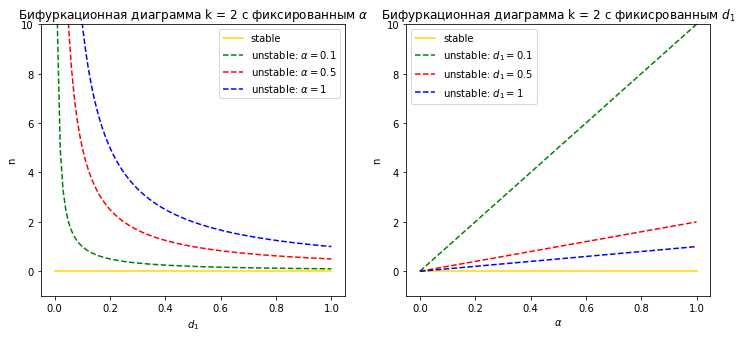

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
x = np.linspace(0.0001, 1, 100)

n_1 = 0 * x
n_2 = 0.1 / x
n_3 = 0.5 / x
n_4 = 1 / x

ax1.set_title(r"Бифуркационная диаграмма k = 2 с фиксированным $\alpha$")
ax1.set_ylabel("n")
ax1.set_xlabel(r"$d_1$")
ax1.plot(x, n_1, color='gold', label="stable")
ax1.plot(x, n_2, 'g--', label=r"unstable: $\alpha = 0.1$")
ax1.plot(x, n_3, 'r--', label=r"unstable: $\alpha = 0.5$")
ax1.plot(x, n_4, 'b--', label=r"unstable: $\alpha = 1$")
ax1.legend()
ax1.set_ylim([-1, 10])

##########################################################################

n2_1 = 0 * x
n2_2 = x / 0.1
n2_3 = x / 0.5
n2_4 = x / 1

ax2.set_title(r"Бифуркационная диаграмма k = 2 с фикисрованным $d_1$")
ax2.set_ylabel("n")
ax2.set_xlabel(r"$\alpha$")
ax2.plot(x, n2_1, color='gold', label="stable")
ax2.plot(x, n2_2, 'g--', label=r"unstable: $d_1 = 0.1$")
ax2.plot(x, n2_3, 'r--', label=r"unstable: $d_1 = 0.5$")
ax2.plot(x, n2_4, 'b--', label=r"unstable: $d_1 = 1$")
ax2.legend()
ax2.set_ylim([-1, 10])

# 1.1) k произведений

$$
    \frac{dn_1}{dt} = -\alpha_1 n + d_1n^k \\
$$

**k - четное:**
$$
    n_1 = 0 \\
    n_2 = \sqrt[k-1]{\frac{\alpha}{d_1}}, \: d_1 \neq 0
$$
(устойчивость аналогично, как у k = 2)

**k - нечетное:**
$$
    n_1 = 0 \\
    n_2 = \sqrt[k-1]{\frac{\alpha}{d_1}}, \: d_1 \neq 0 \\
    n_3 = -\sqrt[k-1]{\frac{\alpha}{d_1}}, \: d_1 \neq 0
$$
(устойчивость для $n_1, n_2$ как у k = 2). Рассмотрим $n_3$:
$$
    [-\alpha + k d_1 n^{k - 1}](-\sqrt[k-1]{\frac{\alpha}{d_1}}) - \lambda \Rightarrow \lambda = (k - 1)\alpha
$$
неустойчивая

C:\Users\dzhun\AppData\Local\Temp\ipykernel_8612\4059282946.py:8: RuntimeWarning: divide by zero encountered in true_divide
  n_21 = 0.1 / x1
C:\Users\dzhun\AppData\Local\Temp\ipykernel_8612\4059282946.py:9: RuntimeWarning: divide by zero encountered in true_divide
  n_22 = 0.1 / x2
C:\Users\dzhun\AppData\Local\Temp\ipykernel_8612\4059282946.py:11: RuntimeWarning: divide by zero encountered in true_divide
  n_31 = 0.5 / x1
C:\Users\dzhun\AppData\Local\Temp\ipykernel_8612\4059282946.py:12: RuntimeWarning: divide by zero encountered in true_divide
  n_32 = 0.5 / x2
C:\Users\dzhun\AppData\Local\Temp\ipykernel_8612\4059282946.py:14: RuntimeWarning: divide by zero encountered in true_divide
  n_41 = 1 / x1
C:\Users\dzhun\AppData\Local\Temp\ipykernel_8612\4059282946.py:15: RuntimeWarning: divide by zero encountered in true_divide
  n_42 = 1 / x2


(-2.0, 2.0)

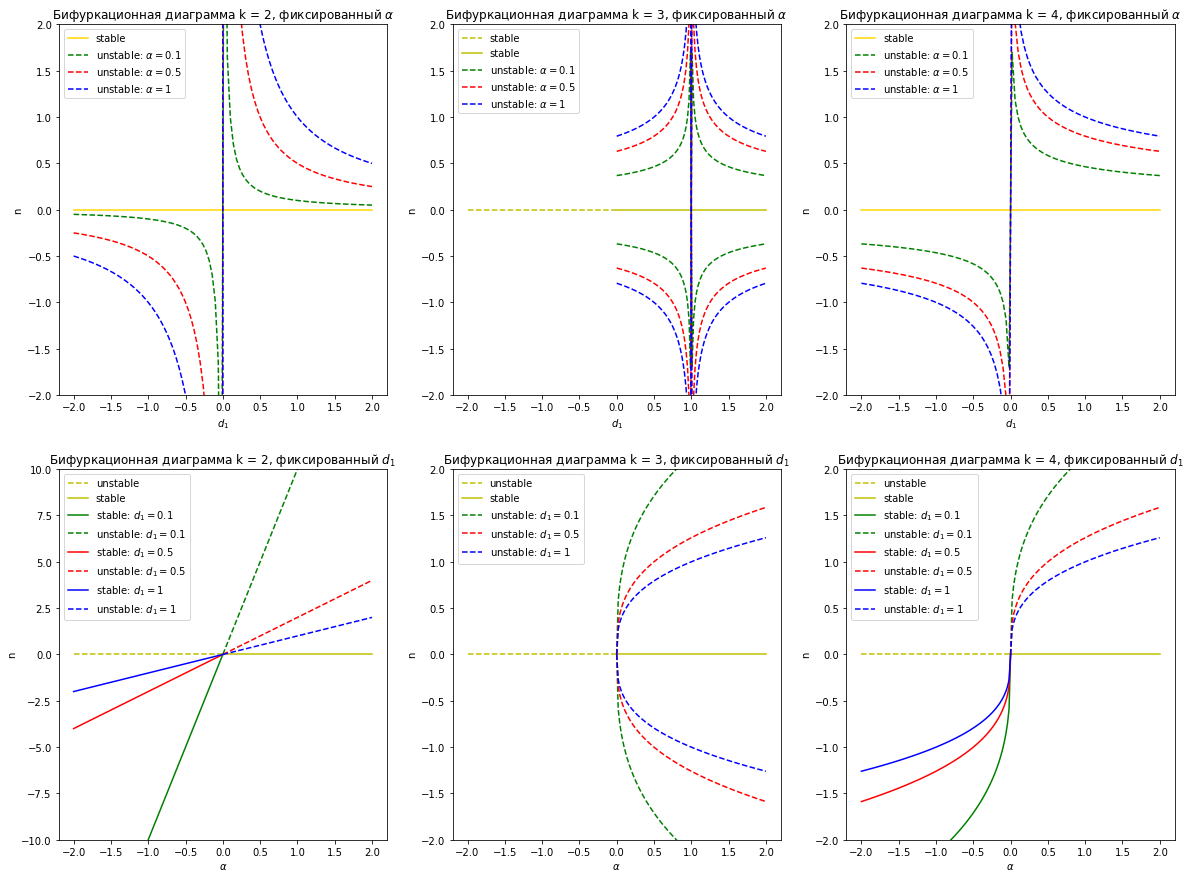

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(20,15))
x1 = np.linspace(-2, 0, 100)
x2 = np.linspace(0, 2, 100)

n_11 = 0 * x1
n_12 = 0 * x2

n_21 = 0.1 / x1
n_22 = 0.1 / x2

n_31 = 0.5 / x1
n_32 = 0.5 / x2

n_41 = 1 / x1
n_42 = 1 / x2

ax[0][0].set_title(r"Бифуркационная диаграмма k = 2, фиксированный $\alpha$")
ax[0][0].set_ylabel("n")
ax[0][0].set_xlabel(r"$d_1$")
ax[0][0].plot(x, n_1, color='gold', label="stable")
ax[0][0].plot(x, n_2, 'g--', label=r"unstable: $\alpha = 0.1$")
ax[0][0].plot(x, n_3, 'r--', label=r"unstable: $\alpha = 0.5$")
ax[0][0].plot(x, n_4, 'b--', label=r"unstable: $\alpha = 1$")
ax[0][0].legend()
ax[0][0].set_ylim([-2, 2])

ax[0][1].set_title(r"Бифуркационная диаграмма k = 3, фиксированный $\alpha$")
ax[0][1].set_ylabel("n")
ax[0][1].set_xlabel(r"$d_1$")
ax[0][1].plot(x1, np.cbrt(n_11), 'y--', label="stable")
ax[0][1].plot(x2, np.cbrt(n_12), 'y-', label='stable')

ax[0][1].plot(x2, np.cbrt(n_2), 'g--', label=r"unstable: $\alpha = 0.1$")
ax[0][1].plot(x2, -np.cbrt(n_2), 'g--')
ax[0][1].plot(x2, np.cbrt(n_3), 'r--', label=r"unstable: $\alpha = 0.5$")
ax[0][1].plot(x2, -np.cbrt(n_3), 'r--')
ax[0][1].plot(x2, np.cbrt(n_4), 'b--', label=r"unstable: $\alpha = 1$")
ax[0][1].plot(x2, -np.cbrt(n_4), 'b--')
ax[0][1].legend()
ax[0][1].set_ylim([-2, 2])

ax[0][2].set_title(r"Бифуркационная диаграмма k = 4, фиксированный $\alpha$")
ax[0][2].set_ylabel("n")
ax[0][2].set_xlabel(r"$d_1$")
ax[0][2].plot(x, np.cbrt(n_1), color='gold', label="stable")
ax[0][2].plot(x, np.cbrt(n_2), 'g--', label=r"unstable: $\alpha = 0.1$")
ax[0][2].plot(x, np.cbrt(n_3), 'r--', label=r"unstable: $\alpha = 0.5$")
ax[0][2].plot(x, np.cbrt(n_4), 'b--', label=r"unstable: $\alpha = 1$")
ax[0][2].legend()
ax[0][2].set_ylim([-2, 2])

##############################################################################

n2_11 = 0 * x1
n2_12 = 0 * x2

n2_21 = x1 / 0.1
n2_22 = x2 / 0.1

n2_31 = x1 / 0.5
n2_32 = x2 / 0.5

n2_41 = x1 / 1
n2_42 = x2 / 1

ax[1][0].set_title(r"Бифуркационная диаграмма k = 2, фиксированный $d_1$")
ax[1][0].set_ylabel("n")
ax[1][0].set_xlabel(r"$\alpha$")
ax[1][0].plot(x1, n2_11, 'y--', label="unstable")
ax[1][0].plot(x2, n2_12, 'y-', label='stable')

ax[1][0].plot(x1, n2_21, 'g-', label=r"stable: $d_1 = 0.1$")
ax[1][0].plot(x2, n2_22, 'g--', label=r"unstable: $d_1 = 0.1$")

ax[1][0].plot(x1, n2_31, 'r-', label=r"stable: $d_1 = 0.5$")
ax[1][0].plot(x2, n2_32, 'r--', label=r"unstable: $d_1 = 0.5$")

ax[1][0].plot(x1, n2_41, 'b-', label=r"stable: $d_1 = 1$")
ax[1][0].plot(x2, n2_42, 'b--', label=r"unstable: $d_1 = 1$")

ax[1][0].legend()
ax[1][0].set_ylim([-10, 10])

ax[1][1].set_title(r"Бифуркационная диаграмма k = 3, фиксированный $d_1$")
ax[1][1].set_ylabel("n")
ax[1][1].set_xlabel(r"$\alpha$")
ax[1][1].plot(x1, np.cbrt(n2_11), 'y--', label="unstable")
ax[1][1].plot(x2, np.cbrt(n2_12), 'y-', label="stable")

ax[1][1].plot(x2, np.cbrt(n2_22), 'g--', label=r"unstable: $d_1 = 0.1$")
ax[1][1].plot(x2, -np.cbrt(n2_22), 'g--')
ax[1][1].plot(x2, np.cbrt(n2_32), 'r--', label=r"unstable: $d_1 = 0.5$")
ax[1][1].plot(x2, -np.cbrt(n2_32), 'r--')
ax[1][1].plot(x2, np.cbrt(n2_42), 'b--', label=r"unstable: $d_1 = 1$")
ax[1][1].plot(x2, -np.cbrt(n2_42), 'b--')
ax[1][1].legend()
ax[1][1].set_ylim([-2, 2])

ax[1][2].set_title(r"Бифуркационная диаграмма k = 4, фиксированный $d_1$")
ax[1][2].set_ylabel("n")
ax[1][2].set_xlabel(r"$\alpha$")
ax[1][2].plot(x1, np.cbrt(n2_11), 'y--', label="unstable")
ax[1][2].plot(x2, np.cbrt(n2_12), 'y-', label='stable')

ax[1][2].plot(x1, np.cbrt(n2_21), 'g-', label=r"stable: $d_1 = 0.1$")
ax[1][2].plot(x2, np.cbrt(n2_22), 'g--', label=r"unstable: $d_1 = 0.1$")

ax[1][2].plot(x1, np.cbrt(n2_31), 'r-', label=r"stable: $d_1 = 0.5$")
ax[1][2].plot(x2, np.cbrt(n2_32), 'r--', label=r"unstable: $d_1 = 0.5$")

ax[1][2].plot(x1, np.cbrt(n2_41), 'b-', label=r"stable: $d_1 = 1$")
ax[1][2].plot(x2, np.cbrt(n2_42), 'b--', label=r"unstable: $d_1 = 1$")

# ax[1][2].plot(x1, np.cbrt(n2_11), 'y-', label="unstable")
# ax[1][2].plot(x2, np.cbrt(n2_12), 'y--', label='stable')
# ax[1][2].plot(x, np.cbrt(n2_2), 'g--', label=r"unstable: $d_1 = 0.1$")
# ax[1][2].plot(x, np.cbrt(n2_3), 'r--', label=r"unstable: $d_1 = 0.5$")
# ax[1][2].plot(x, np.cbrt(n2_4), 'b--', label=r"unstable: $d_1 = 1$")
ax[1][2].legend()
ax[1][2].set_ylim([-2, 2])

$$
    \frac{dn_1}{dt} = -\alpha_1 n + d_1n^k \\
$$

Если рассматривать пространство параметров ($\lambda$, $d_1$), то появляется кандидат на бифуркацию напрямой (0, $d_1$), а также на прямой ($\alpha$, 0). При пересечении этих прямых получается еще одна бифуркация (0, 0).

Что это за бифуркации:

**1)** На прямой ($\alpha$, 0), уравнение имеет единственную устойчивую особую точку 0. При $\forall \alpha \neq 0$ при малейшем изменении $d_1$ получаем (2 или 1 особую неустойчивую точку в $\pm \sqrt[k-1]{\frac{\alpha}{d_1}}$ и 1 устойчивую в 0):

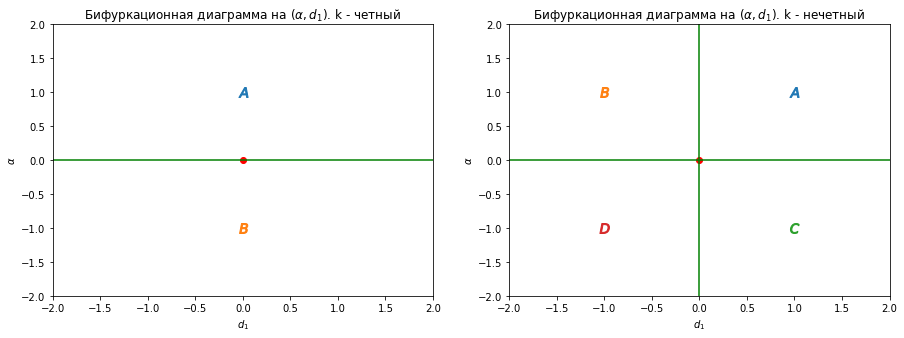

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
x = np.linspace(-2, 2, 100)

f1 = 0 * x
f2 = 0 * x

ax[0].set_title(r"Бифуркационная диаграмма на ($\alpha, d_1$). k - четный")
ax[0].set_ylabel(r"$\alpha$")
ax[0].set_xlabel(r"$d_1$")
ax[0].plot(x, f1, color='green')
# ax[0].plot(f2, x, color='green')
ax[0].set_ylim([-2, 2])
ax[0].set_xlim([-2, 2])
ax[0].scatter([0], [0], color='red')
ax[0].scatter([0], [1], s = 100, marker='$A$')
ax[0].scatter([0], [-1], s = 100, marker='$B$')
# ax[0].scatter([1], [-1], s = 100, marker='$C$')
# ax[0].scatter([-1], [-1], s = 100, marker='$D$')

ax[1].set_title(r"Бифуркационная диаграмма на ($\alpha, d_1$). k - нечетный")
ax[1].set_ylabel(r"$\alpha$")
ax[1].set_xlabel(r"$d_1$")
ax[1].plot(x, f1, color='green')
ax[1].plot(f2, x, color='green')
ax[1].set_ylim([-2, 2])
ax[1].set_xlim([-2, 2])
ax[1].scatter([0], [0], color='red')
ax[1].scatter([1], [1], s = 100, marker='$A$')
ax[1].scatter([-1], [1], s = 100, marker='$B$')
ax[1].scatter([1], [-1], s = 100, marker='$C$')
ax[1].scatter([-1], [-1], s = 100, marker='$D$')

нечетный k.

$$
    \frac{dn}{dt} = -\alpha + d_1 n^k
$$

V(n) = $-\alpha + d_1n^k$ принимает значение 0. Положим $d_1 \neq 0$, тогда введем замену V(n) $\to$ V(m), где $m = \sqrt[k]{d_1} n$, тогда 
\begin{equation}\label{catf}
    \frac{dm}{dt} = -\gamma m  + m^k
\end{equation}
где $\gamma = \frac{\alpha}{d_1}$. Основоным показателем существования катастрофы является наличие вырожденной критической точки. Тогда решим следующую систему:
\begin{equation}\label{catsys}
    \begin{cases}
        \frac{dV}{dn} = -\gamma + km^{k-1} \\
        \frac{d^2V}{dn^2} = k(k-1)m^{k-2} \\
    \end{cases}
\end{equation}

$$\gamma = 0$$

(-2.0, 2.0)

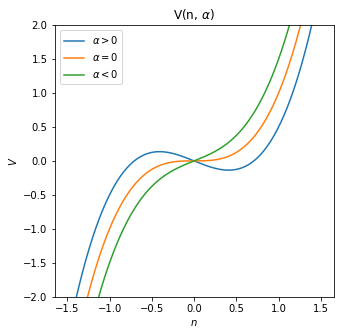

In [82]:
plt.figure(figsize=(5, 5))
x = np.linspace(-1.5, 1.5, 500)

f1 = -0.5*x + x*x*x
f2 = x*x*x
f3 = 0.5*x + x*x*x

plt.title(r"V(n, $\alpha$)")
plt.ylabel(r"$V$")
plt.xlabel(r"$n$")

plt.plot(x, f1, label=r"$\alpha > 0$")
plt.plot(x, f2, label=r"$\alpha = 0$")
plt.plot(x, f3, label=r"$\alpha < 0$")
plt.legend()

plt.ylim([-2,2])

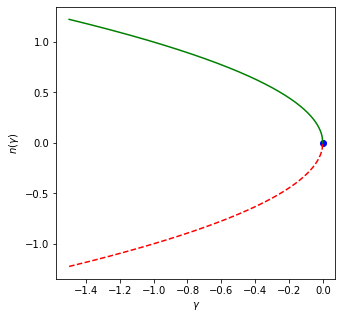

In [87]:
plt.figure(figsize=(5, 5))
x = np.linspace(-1.5, 0, 500)

f1 = np.sqrt(-x)
f2 = -np.sqrt(-x)

plt.xlabel(r"$\gamma$")
plt.ylabel(r"$n(\gamma)$")
plt.plot(x, f1, 'g-')
plt.plot(x, f2, 'r--')
plt.scatter([0], [0], color="blue")

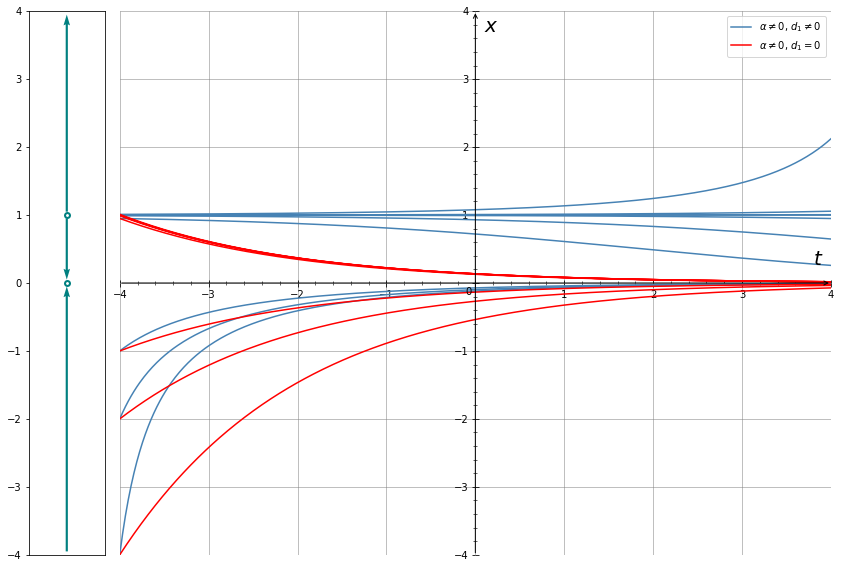

In [139]:
plt.figure(figsize=(16, 10))
plt.subplot2grid((1, 10), (0, 0))
plt.xlim(-0.5, 0.5)
plt.xticks([], [])
plt.ylim(-4, 4)
onedim_phasecurves(-4, 4, [0, 1], [1, -1, 1])
plt.subplot2grid((1, 10), (0, 1), colspan=8)
axes4x4()
def f1(t, x):
    return -0.5 * x + 0.5 * x * x

def f2(t, x):
    return -0.5 * x + 0 * x * x

plt.plot(np.arange(5), 0 * np.arange(5) + 10, color='steelblue', label=r"$\alpha \neq 0$, $d_1 \neq 0$")
plt.plot(np.arange(5), 0 * np.arange(5) + 10, color='red', label=r"$\alpha \neq 0$, $d_1 = 0$")
# plt.title(r"blue : $\alpha \neq 0$, $d_1 \neq 0$ red : $\alpha \neq 0$; $d_1 = 0$")
for x0 in [1.0001, 1.001, 1.01, 1, 0.95, 0.99, 0.999, -1, -2, -4]:
    eulersplot(f1, -4, 4, x0, color='steelblue')
    
for x0 in [1.0001, 1.001, 1.01, 1, 0.95, 0.99, 0.999, -1, -2, -4]:
    eulersplot(f2, -4, 4, x0, color='red')

plt.legend()

**2)** На прямой $(0, d_1)$ уравнение имеет единственную особую точку в $n = 0$. При $\alpha \neq 0$, аналогично бифуркации 1.

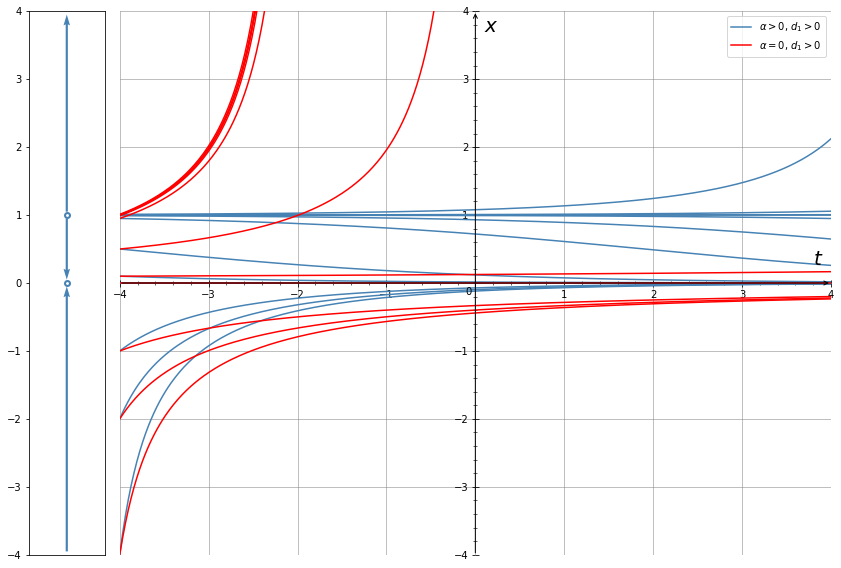

In [56]:
plt.figure(figsize=(16, 10))
plt.subplot2grid((1, 10), (0, 0))
plt.xlim(-0.5, 0.5)
plt.xticks([], [])
plt.ylim(-4, 4)
onedim_phasecurves(-4, 4, [0, 1], [1, -1, 1])
plt.subplot2grid((1, 10), (0, 1), colspan=8)
axes4x4()
def f1(t, x):
    return -0.5 * x + 0.5 * x * x

def f2(t, x):
    return 0 * x + 0.5 * x * x

def f3(t, x):
    return 0.5 * x + 0.5 * x * x

# plt.title(r"blue : $\alpha > 0$, $d_1 > 0$ red : $\alpha = 0$; $d_1 > 0$")

plt.plot(np.arange(5), 0 * np.arange(5) + 10, color='steelblue', label=r"$\alpha > 0$, $d_1 > 0$")
plt.plot(np.arange(5), 0 * np.arange(5) + 10, color='red', label=r"$\alpha = 0$, $d_1 > 0$")
plt.legend()

for x0 in [1.0001, 1.001, 1.01, 1, 0, 0.1, 0.5, 0.95, 0.99, 0.999, -1, -2, -4]:
    eulersplot(f1, -4, 4, x0, color='steelblue')
    
for x0 in [1.0001, 1.001, 1.01, 1, 0, 0.1, 0.5, 0.95, 0.99, 0.999, -1, -2, -4]:
    eulersplot(f2, -4, 4, x0, color='red')

По интегральной кривой можно заметить, что 0 это неустойчивая особая точка

**3)** На пересечении этих множеств бифуркации получается новая точка бифуркации (0, 0). Где особые точки это все n

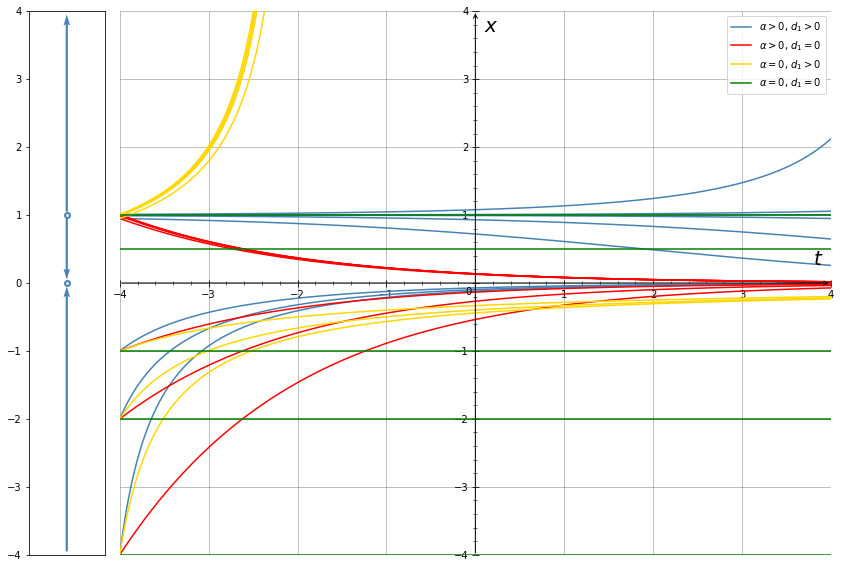

In [52]:
plt.figure(figsize=(16, 10))
plt.subplot2grid((1, 10), (0, 0))
plt.xlim(-0.5, 0.5)
plt.xticks([], [])
plt.ylim(-4, 4)
onedim_phasecurves(-4, 4, [0, 1], [1, -1, 1])
plt.subplot2grid((1, 10), (0, 1), colspan=8)
axes4x4()
def f1(t, x):
    return -0.5 * x + 0.5 * x * x

def f2(t, x):
    return -0.5 * x + 0 * x * x

def f3(t, x):
    return 0 * x + 0.5 * x * x

def f4(t, x):
    return 0

# plt.title(r"blue : $\alpha \neq 0$, $d_1 \neq 0$. red : $\alpha \neq 0$; $d_1 = 0$. yellow : $\alpha = 0, d_1 \neq 0$. green : $\alpha = 0, d_1 = 0$")
plt.plot(np.arange(5), 0 * np.arange(5) + 10, color='steelblue', label=r"$\alpha > 0$, $d_1 > 0$")
plt.plot(np.arange(5), 0 * np.arange(5) + 10, color='red', label=r"$\alpha > 0$, $d_1 = 0$")
plt.plot(np.arange(5), 0 * np.arange(5) + 10, color='gold', label=r"$\alpha = 0$, $d_1 > 0$")
plt.plot(np.arange(5), 0 * np.arange(5) + 10, color='green', label=r"$\alpha = 0$, $d_1 = 0$")
plt.legend()
for x0 in [1.0001, 1.001, 1.01, 0.95, 0.99, 0.999, -1, -2, -4]:
    eulersplot(f1, -4, 4, x0, color='steelblue')
    
for x0 in [1.0001, 1.001, 1.01, 0.95, 0.99, 0.999, -1, -2, -4]:
    eulersplot(f2, -4, 4, x0, color='red')
    
for x0 in [1.0001, 1.001, 1.01, 0.95, 0.99, 0.999, -1, -2, -4]:
    eulersplot(f3, -4, 4, x0, color='gold')
    
for x0 in [1.0001, 0.5, -1, -2, -4]:
    eulersplot(f4, -4, 4, x0, color='green')

# 2) Два уравнения два произведения

$$
    \begin{cases}
        \frac{dn_1}{dt} = -\alpha_1 n_1 + d^{(1)}_{11}n^2_1 + 2d^{(1)}_{12}n_1n_2 + d^{(1)}_{22}n^2_2 \\
        \frac{dn_2}{dt} = -\alpha_2 n_2 + d^{(2)}_{11}n^2_1 + 2d^{(2)}_{12}n_1n_2 + d^{(2)}_{22}n^2_2 \\
    \end{cases} \: \clubsuit
$$

Пусть $n_0$ какая-то уже найденная особая точка, тогда линеаризация приинимает вид:

$$
    \begin{equation}\label{Fdiff}
    F(n) = F(n_0) + \left.\frac{dF}{dn}\right|_{n = n_0} \cdot (n - n_0) + o(||n - n_0||)
    \end{equation}
$$

$$
\left.\frac{dF}{dn} \right|_{n = n_0} = J_{(n_1, n_2)} = 
    \begin{pmatrix}
        -\alpha_1 + 2d_{11}^{(1)}n_1 + 2d^{(1)}_{12}n_2 && 2d^{(1)}_{12}n_1 + 2d^{(1)}_{22}n_2 \\
        2d_{11}^{(2)}n_1 + 2d_{12}^{(2)}n_2 && -\alpha_2 + 2d_{12}^{(2)}n_1 + 2d_{22}^{(2)}n_2 \\
    \end{pmatrix}
$$

$$
    w = n - n_0 \Rightarrow \frac{dw}{dt} = J(n_1, n_2)w
$$

**Выведены вспомогательные фукнции:**


$$
    D_{\chi} = (\alpha_1 - \alpha_2)^2 + 4(\alpha_2 - \alpha_1)(d^{(1)}_{11} - d^{(2)}_{12})n_1 + 4(\alpha_1 - \alpha_2)(d^{(2)}_{22} - d^{(1)}_{12})n_2 + \\
    + 4((d_{11}^{(1)} - d_{12}^{(2)})^2 + 4d_{11}^{(2)}d_{12}^{(1)}))n_1^2 + 
    8((d_{11}^{(1)} + d_{12}^{(2)})(d_{12}^{(1)} + d_{22}^{(2)}) - 2(d_{11}^{(1)}d_{22}^{(2)} -d_{11}^{(2)}d_{22}^{(1)}))n_1n_2
    + 4((d_{12}^{(1)} - d_{22}^{(2)})^2 + 4d_{22}^{(1)}d_{12}^{(2)}))n^2_2
$$

Тогда:

$$
    D_{\chi} \geq 0 \Rightarrow Im(\lambda_{1, 2}) = 0 
$$

$$
    D_{\chi} < 0 \Rightarrow Im(\lambda_{1, 2}) \neq 0
$$

$$
        D_1 = -\frac{\alpha_1 + \alpha_2}{2} + (d_{11}^{(1)} + d_{12}^{(2)})n_1 + (d_{12}^{(1)} + d_{22}^{(2)})n_2 - I_{D_\chi \geq 0} \cdot \frac{\sqrt{D_\chi}}{2}
$$

$$
        D_2 = -\frac{\alpha_1 + \alpha_2}{2} + (d_{11}^{(1)} + d_{12}^{(2)})n_1 + (d_{12}^{(1)} + d_{22}^{(2)})n_2 + I_{D_\chi \geq 0} \cdot \frac{\sqrt{D_\chi}}{2}
$$

$$
Re_{\lambda_1} \lessgtr 0 \Leftrightarrow D_1 \lessgtr 0
$$

$$
    Re_{\lambda_2} \lessgtr 0 \Leftrightarrow D_2 \lessgtr 0
$$

# Результаты перебора параметров по $\clubsuit$:

**Шаг 0.2:**

In [2]:
import glob

In [96]:
df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p2/*.csv')))
df.to_csv("merged_step0p2.csv")

In [8]:
params_df_orig = pd.read_csv("merged_step0p2.csv")
params_df_orig

C:\Users\dzhun\AppData\Local\Temp\ipykernel_12328\3940902387.py:1: DtypeWarning: Columns (24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  params_df_orig = pd.read_csv("merged_step0p2.csv")


,Unnamed: 0,p1,p2,p3,p4,p5,p6,p7,p8,number_of_solutions,...,is_singular,is_complex,1e1,1e2,2e1,2e2,3e1,3e2,4e1,4e2
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999,...,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,999,...,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,999,...,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,999,...,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,999,...,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679595,16791,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0.6,2,...,0,0,-1.0,-1.0,0.9999999999999998,-1.2087031980774403,NaN,NaN,NaN,NaN
1679596,16792,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0.8,2,...,0,0,-1.0,-1.0,1.0,-1.1390378243963672,NaN,NaN,NaN,NaN
1679597,16793,1.0,1.0,1.0,1.0,1.0,1.0,0.4,1.0,2,...,0,0,1.0,-1.0700622524628085,-1.0,-1.0,NaN,NaN,NaN,NaN
1679598,16794,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.0,1,...,0,0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
params_df_orig.dtypes

Unnamed: 0               int64
p1                     float64
p2                     float64
p3                     float64
p4                     float64
p5                     float64
p6                     float64
p7                     float64
p8                     float64
number_of_solutions      int64
x1                     float64
y1                     float64
x2                     float64
y2                     float64
x3                     float64
y3                     float64
x4                     float64
y4                     float64
is_singular              int64
is_complex               int64
1e1                     object
1e2                     object
2e1                     object
2e2                     object
3e1                     object
3e2                     object
4e1                     object
4e2                     object
dtype: object

In [10]:
param_df = params_df_orig.drop(['is_complex'], axis=1)

In [11]:
param_df

,Unnamed: 0,p1,p2,p3,p4,p5,p6,p7,p8,number_of_solutions,...,y4,is_singular,1e1,1e2,2e1,2e2,3e1,3e2,4e1,4e2
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999,...,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,999,...,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,999,...,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,999,...,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,999,...,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679595,16791,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0.6,2,...,NaN,0,-1.0,-1.0,0.9999999999999998,-1.2087031980774403,NaN,NaN,NaN,NaN
1679596,16792,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0.8,2,...,NaN,0,-1.0,-1.0,1.0,-1.1390378243963672,NaN,NaN,NaN,NaN
1679597,16793,1.0,1.0,1.0,1.0,1.0,1.0,0.4,1.0,2,...,NaN,0,1.0,-1.0700622524628085,-1.0,-1.0,NaN,NaN,NaN,NaN
1679598,16794,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.0,1,...,NaN,0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN


Создаем дополнительные признаки, указывающие класс особых точек

In [12]:
import math

def get_class(obj1, obj2):
    
    # 0 - stable node
    # 1 - unstable node
    # 2 - saddle
    # 3 - complex (cycle, center)
    # 4 - degenerate class
    # 5 - NaN (empty point)
    try:
        real_lambda1 = float(obj1)
        real_lambda2 = float(obj2)
        
        if math.isnan(real_lambda1) or math.isnan(real_lambda2):
            return 5
        
        if real_lambda1 < 0 and real_lambda2 < 0:
            return 0
        elif real_lambda1 > 0 and real_lambda2 > 0:
            return 1
        elif real_lambda1 > 0 and real_lambda2 < 0 or real_lambda1 < 0 and real_lambda2 > 0:
            return 2
        else:
            return 4
    except ValueError:
        return 3


p1 = []
p2 = []
p3 = []
p4 = []
for index, row in param_df.iterrows():
    p1.append(get_class(row['1e1'], row['1e2']))
    p2.append(get_class(row['2e1'], row['2e2']))
    p3.append(get_class(row['3e1'], row['3e2']))
    p4.append(get_class(row['4e1'], row['4e2']))

print(len(p1), len(p2), len(p3), len(p4))

1679600 1679600 1679600 1679600


In [13]:
param_df['pc1'] = p1
param_df['pc2'] = p2
param_df['pc3'] = p3
param_df['pc4'] = p4

In [14]:
print('\033[1m' + "Point 1:" + '\033[0m')
print(param_df['pc1'].value_counts())

print('\033[1m' + "Point 2:" + '\033[0m')
print(param_df['pc2'].value_counts())

print('\033[1m' + "Point 3:" + '\033[0m')
print(param_df['pc3'].value_counts())

print('\033[1m' + "Point 4:" + '\033[0m')
print(param_df['pc4'].value_counts())

Point 1:
2    571813
0    496445
4    330735
1    235810
3     44797
Name: pc1, dtype: int64
Point 2:
5    588315
0    453024
2    360410
4    126174
1    117381
3     34296
Name: pc2, dtype: int64
Point 3:
5    1163814
2     217142
0     103551
4      94884
1      78957
3      21252
Name: pc3, dtype: int64
Point 4:
5    1416669
0     115606
2      95307
1      45626
3       6392
Name: pc4, dtype: int64


In [ ]:
param

Дополнительная таблица всех особых точек и их классов для визуализации:

In [125]:
px = []
py = []
pc = []

for index, row in param_df.iterrows():
    if row['pc1'] != 5:
        px.append(row['x1'])
        py.append(row['y1'])
        pc.append(row['pc1'])
    
    if row['pc2'] != 5:
        px.append(row['x2'])
        py.append(row['y2'])
        pc.append(row['pc2'])
    
    if row['pc3'] != 5:
        px.append(row['x3'])
        py.append(row['y3'])
        pc.append(row['pc3'])
    
    if row['pc4'] != 5:
        px.append(row['x4'])
        py.append(row['y4'])
        pc.append(row['pc4'])

print(len(px), len(py), len(pc))

3549602 3549602 3549602


In [127]:
points_df = pd.DataFrame({
    'x': px,
    'y': py,
    'class': pc
})

points_df

,x,y,class
0,0.000000,0.000000,4
1,0.000000,0.000000,4
2,0.000000,0.000000,4
3,0.000000,0.000000,4
4,0.000000,0.000000,4
...,...,...,...
3549597,0.000000,0.000000,0
3549598,0.000000,0.000000,0
3549599,0.355563,0.240728,2
3549600,4.394437,-6.490728,2


# Визуализация особых точек

<AxesSubplot:xlabel='x', ylabel='y'>

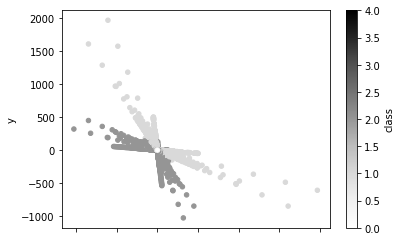

In [128]:
points_df.plot.scatter(x = 'x', y = 'y')

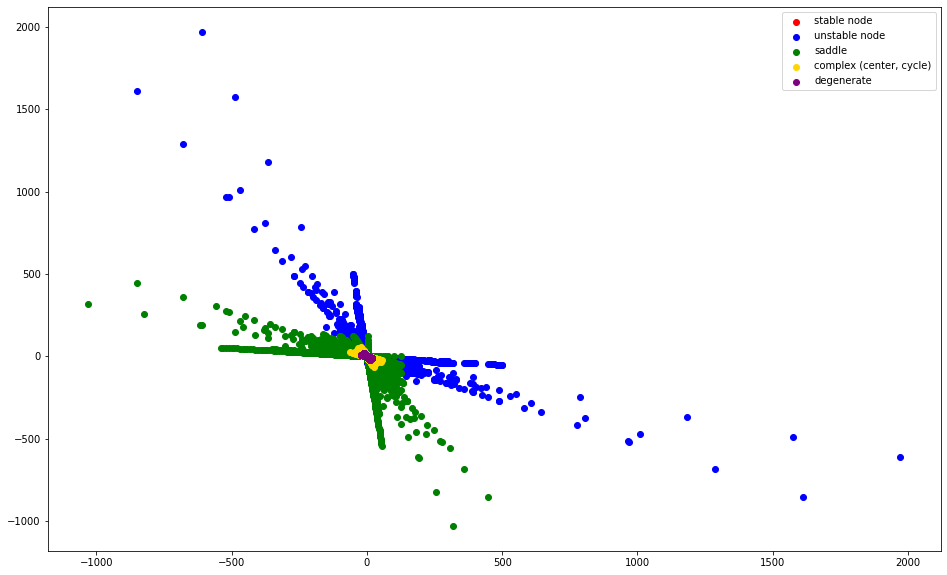

In [132]:
plt.figure(figsize=(16, 10))
plt.scatter(points_df[points_df['class'] == 0]['x'], points_df[points_df['class'] == 0]['y'], color='red', label='stable node')
plt.scatter(points_df[points_df['class'] == 1]['x'], points_df[points_df['class'] == 1]['y'], color='blue', label='unstable node')
plt.scatter(points_df[points_df['class'] == 2]['x'], points_df[points_df['class'] == 2]['y'], color='green', label='saddle')
plt.scatter(points_df[points_df['class'] == 3]['x'], points_df[points_df['class'] == 3]['y'], color='gold', label='complex (center, cycle)')
plt.scatter(points_df[points_df['class'] == 4]['x'], points_df[points_df['class'] == 4]['y'], color='purple', label='degenerate')

plt.legend()

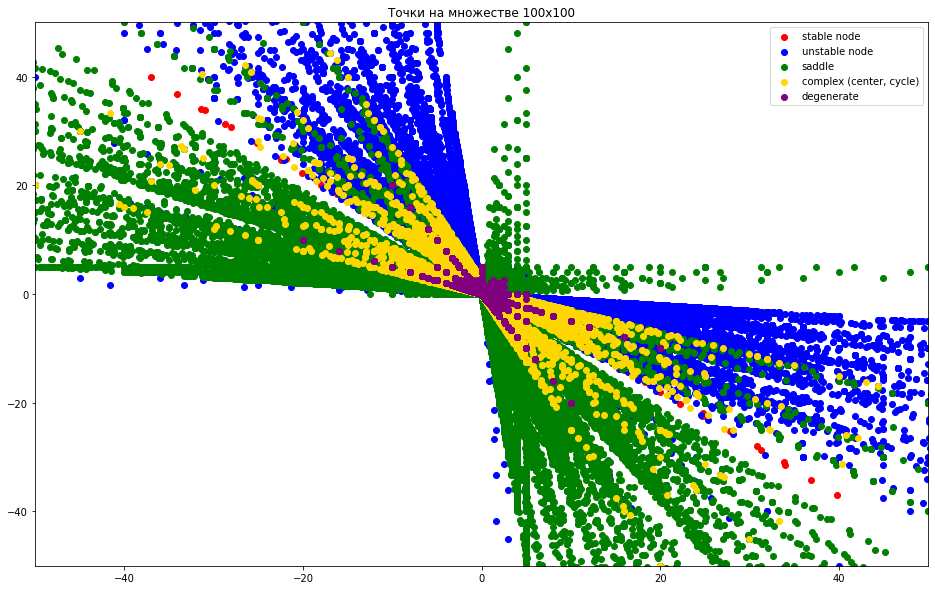

In [134]:
plt.figure(figsize=(16, 10))

plt.scatter(points_df[points_df['class'] == 0]['x'], points_df[points_df['class'] == 0]['y'], color='red', label='stable node')
plt.scatter(points_df[points_df['class'] == 1]['x'], points_df[points_df['class'] == 1]['y'], color='blue', label='unstable node')
plt.scatter(points_df[points_df['class'] == 2]['x'], points_df[points_df['class'] == 2]['y'], color='green', label='saddle')
plt.scatter(points_df[points_df['class'] == 3]['x'], points_df[points_df['class'] == 3]['y'], color='gold', label='complex (center, cycle)')
plt.scatter(points_df[points_df['class'] == 4]['x'], points_df[points_df['class'] == 4]['y'], color='purple', label='degenerate')

plt.title("Точки на множестве 100x100")
plt.xlim([-50, 50])
plt.ylim([-50, 50])
plt.legend()

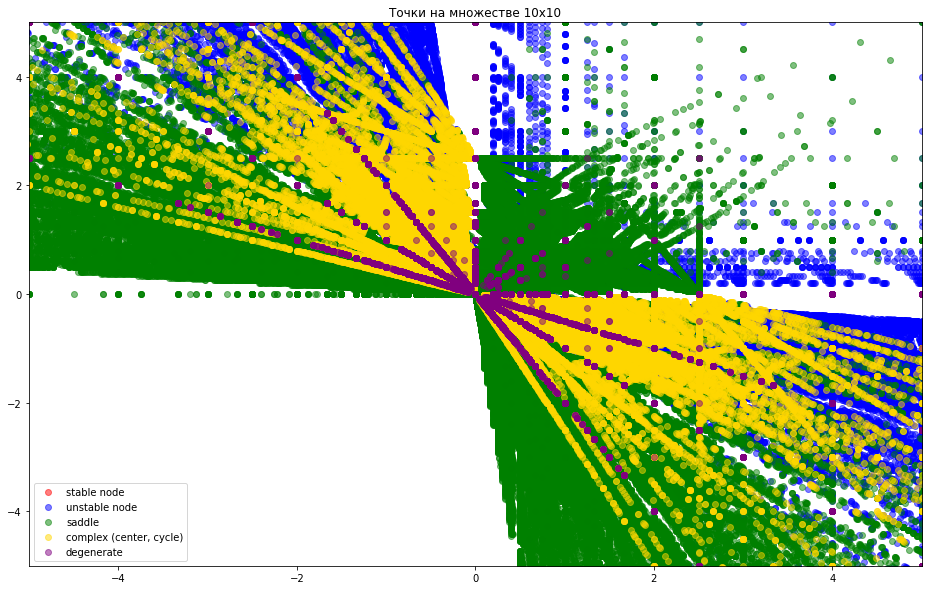

In [136]:
plt.figure(figsize=(16, 10))

plt.scatter(points_df[points_df['class'] == 0]['x'], points_df[points_df['class'] == 0]['y'], alpha=0.5, color='red', label='stable node')
plt.scatter(points_df[points_df['class'] == 1]['x'], points_df[points_df['class'] == 1]['y'], alpha=0.5, color='blue', label='unstable node')
plt.scatter(points_df[points_df['class'] == 2]['x'], points_df[points_df['class'] == 2]['y'], alpha=0.5, color='green', label='saddle')
plt.scatter(points_df[points_df['class'] == 3]['x'], points_df[points_df['class'] == 3]['y'], alpha=0.5, color='gold', label='complex (center, cycle)')
plt.scatter(points_df[points_df['class'] == 4]['x'], points_df[points_df['class'] == 4]['y'], alpha=0.5, color='purple', label='degenerate')

plt.title("Точки на множестве 10x10")
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.legend()

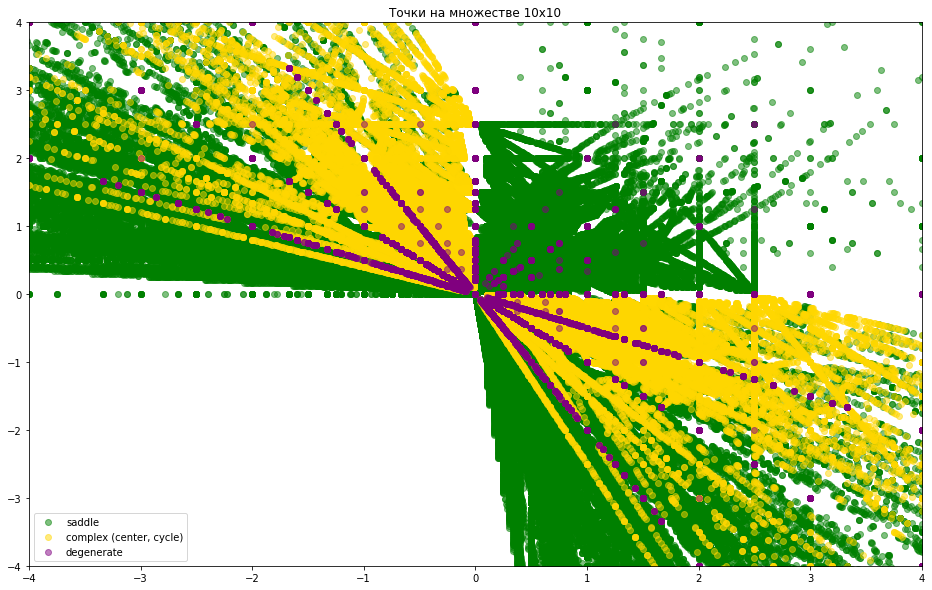

In [141]:
plt.figure(figsize=(16, 10))

plt.scatter(points_df[points_df['class'] == 2]['x'], points_df[points_df['class'] == 2]['y'], alpha=0.5, color='green', label='saddle')
plt.scatter(points_df[points_df['class'] == 3]['x'], points_df[points_df['class'] == 3]['y'], alpha=0.5, color='gold', label='complex (center, cycle)')
plt.scatter(points_df[points_df['class'] == 4]['x'], points_df[points_df['class'] == 4]['y'], alpha=0.5, color='purple', label='degenerate')

plt.title("Точки на множестве 10x10")
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.legend()

# Границы бифуркаций (1). Тут только тип особых точек

$$
    D_{\chi} = (\alpha_1 - \alpha_2)^2 + 4(\alpha_2 - \alpha_1)(d^{(1)}_{11} - d^{(2)}_{12})n_1 + 4(\alpha_1 - \alpha_2)(d^{(2)}_{22} - d^{(1)}_{12})n_2 + \\
    + 4((d_{11}^{(1)} - d_{12}^{(2)})^2 + 4d_{11}^{(2)}d_{12}^{(1)}))n_1^2 + 
    8((d_{11}^{(1)} + d_{12}^{(2)})(d_{12}^{(1)} + d_{22}^{(2)}) - 2(d_{11}^{(1)}d_{22}^{(2)} -d_{11}^{(2)}d_{22}^{(1)}))n_1n_2
    + 4((d_{12}^{(1)} - d_{22}^{(2)})^2 + 4d_{22}^{(1)}d_{12}^{(2)}))n^2_2
$$

$$
    D_{\chi} \geq 0 \Rightarrow Im(\lambda_{1, 2}) = 0 
$$

$$
    D_{\chi} < 0 \Rightarrow Im(\lambda_{1, 2}) \neq 0
$$

$$
        D_1 = -\frac{\alpha_1 + \alpha_2}{2} + (d_{11}^{(1)} + d_{12}^{(2)})n_1 + (d_{12}^{(1)} + d_{22}^{(2)})n_2 - I_{D_\chi \geq 0} \cdot \frac{\sqrt{D_\chi}}{2}
$$

$$
        D_2 = -\frac{\alpha_1 + \alpha_2}{2} + (d_{11}^{(1)} + d_{12}^{(2)})n_1 + (d_{12}^{(1)} + d_{22}^{(2)})n_2 + I_{D_\chi \geq 0} \cdot \frac{\sqrt{D_\chi}}{2}
$$

$$
Re_{\lambda_1} \lessgtr 0 \Leftrightarrow D_1 \lessgtr 0
$$

$$
Re_{\lambda_2} \lessgtr 0 \Leftrightarrow D_2 \lessgtr 0
$$

In [17]:
import math

def Dc(a1, d111, d112, d122, a2, d211, d212, d222, n1, n2):
    return (a1-a2) ** 2 + 4*(a2-a1)*(d111-d212)*n1+4*(a1-a2)*(d222-d112)*n2+4*((d111-d212)**2+4*d211*d112)*n1**2 + 8*((d111+d212)*(d112+d222)-2*(d111*d222-d211*d122))*n1*n2+4*((d112-d222)**2+4*d122*d212)*n2**2

def D1(a1, d111, d112, d122, a2, d211, d212, d222, n1, n2, Dc):
    k = -(a1 + a2)/2 + (d111 + d212)*n1+(d112+d222)*n2
    if Dc >= 0:
        return k - math.sqrt(Dc)/2
    else:
        return k

def D2(a1, d111, d112, d122, a2, d211, d212, d222, n1, n2, Dc):
    k = -(a1 + a2)/2 + (d111 + d212)*n1+(d112+d222)*n2
    if Dc >= 0:
        return k + math.sqrt(Dc)/2
    else:
        return k

Использую предподсчитанные результаты параметров (Шаг 0.12)

In [6]:
df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[0:25]))
df.to_csv("merged_step0p12_0.csv")

C:\Users\dzhun\AppData\Local\Temp\ipykernel_12328\4275707909.py:1: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[0:25]))
C:\Users\dzhun\AppData\Local\Temp\ipykernel_12328\4275707909.py:1: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[0:25]))
C:\Users\dzhun\AppData\Local\Temp\ipykernel_12328\4275707909.py:1: DtypeWarning: Columns (19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[0:25]))
C:\Users\dzhun\AppData\Local\Temp\ipykernel_12328\4275707909.py:1: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.r

In [45]:
df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[25:50]))
df.to_csv("merged_step0p12_1.csv")

C:\Users\dzhun\AppData\Local\Temp\ipykernel_12328\131292200.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[25:50]))
C:\Users\dzhun\AppData\Local\Temp\ipykernel_12328\131292200.py:1: DtypeWarning: Columns (19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[25:50]))
C:\Users\dzhun\AppData\Local\Temp\ipykernel_12328\131292200.py:1: DtypeWarning: Columns (19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[25:50]))


MemoryError: Unable to allocate 52.5 MiB for an array with shape (16, 430467) and data type float64

In [ ]:
df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[50:75]))
df.to_csv("merged_step0p12_2.csv")

In [ ]:
df = pd.concat(map(pd.read_csv, glob.glob('calc_results/complex_step0p12/*.csv')[75:100]))
df.to_csv("merged_step0p12_3.csv")

Для начала шаг 0.2

In [15]:
param_df

,Unnamed: 0,p1,p2,p3,p4,p5,p6,p7,p8,number_of_solutions,...,2e1,2e2,3e1,3e2,4e1,4e2,pc1,pc2,pc3,pc4
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999,...,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,5
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,999,...,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,5
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,999,...,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,5
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,999,...,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,5
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,999,...,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679595,16791,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0.6,2,...,0.9999999999999998,-1.2087031980774403,NaN,NaN,NaN,NaN,0,2,5,5
1679596,16792,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0.8,2,...,1.0,-1.1390378243963672,NaN,NaN,NaN,NaN,0,2,5,5
1679597,16793,1.0,1.0,1.0,1.0,1.0,1.0,0.4,1.0,2,...,-1.0,-1.0,NaN,NaN,NaN,NaN,2,0,5,5
1679598,16794,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,5,5,5


In [18]:
p1 = []
p2 = []
p3 = []
p4 = []
p5 = []
p6 = []
p7 = []
p8 = []
px = []
py = []
pc = []
d_c = []
d_1 = []
d_2 = []

for index, row in param_df.iterrows():
    param1 = row['p1']
    param2 = row['p2']
    param3 = row['p3']
    param4 = row['p4']
    param5 = row['p5']
    param6 = row['p6']
    param7 = row['p7']
    param8 = row['p8']
    
    if row['pc1'] != 5:
        p1.append(param1)
        p2.append(param2)
        p3.append(param3)
        p4.append(param4)
        p5.append(param5)
        p6.append(param6)
        p7.append(param7)
        p8.append(param8)
        
        dc = Dc(param1, param2, param3, param4, param5, param6, param7, param8, row['x1'], row['y1'])
        d1 = D1(param1, param2, param3, param4, param5, param6, param7, param8, row['x1'], row['y1'], dc)
        d2 = D2(param1, param2, param3, param4, param5, param6, param7, param8, row['x1'], row['y1'], dc)
        if dc < 0:
            d_c.append(0)
        else:
            d_c.append(1)
        
        if d1 < 0:
            d_1.append(0)
        else:
            d_1.append(1)
        
        if d2 < 0:
            d_2.append(0)
        else:
            d_2.append(1)
        
        px.append(row['x1'])
        py.append(row['y1'])
        pc.append(row['pc1'])
    
    if row['pc2'] != 5:
        p1.append(param1)
        p2.append(param2)
        p3.append(param3)
        p4.append(param4)
        p5.append(param5)
        p6.append(param6)
        p7.append(param7)
        p8.append(param8)
        
        dc = Dc(param1, param2, param3, param4, param5, param6, param7, param8, row['x2'], row['y2'])
        d1 = D1(param1, param2, param3, param4, param5, param6, param7, param8, row['x2'], row['y2'], dc)
        d2 = D2(param1, param2, param3, param4, param5, param6, param7, param8, row['x2'], row['y2'], dc)
        if dc < 0:
            d_c.append(0)
        else:
            d_c.append(1)
        
        if d1 < 0:
            d_1.append(0)
        else:
            d_1.append(1)
        
        if d2 < 0:
            d_2.append(0)
        else:
            d_2.append(1)
        
        px.append(row['x2'])
        py.append(row['y2'])
        pc.append(row['pc2'])
    
    if row['pc3'] != 5:
        p1.append(param1)
        p2.append(param2)
        p3.append(param3)
        p4.append(param4)
        p5.append(param5)
        p6.append(param6)
        p7.append(param7)
        p8.append(param8)
        
        dc = Dc(param1, param2, param3, param4, param5, param6, param7, param8, row['x3'], row['y3'])
        d1 = D1(param1, param2, param3, param4, param5, param6, param7, param8, row['x3'], row['y3'], dc)
        d2 = D2(param1, param2, param3, param4, param5, param6, param7, param8, row['x3'], row['y3'], dc)
        if dc < 0:
            d_c.append(0)
        else:
            d_c.append(1)
        
        if d1 < 0:
            d_1.append(0)
        else:
            d_1.append(1)
        
        if d2 < 0:
            d_2.append(0)
        else:
            d_2.append(1)
        
        px.append(row['x3'])
        py.append(row['y3'])
        pc.append(row['pc3'])
    
    if row['pc4'] != 5:
        p1.append(param1)
        p2.append(param2)
        p3.append(param3)
        p4.append(param4)
        p5.append(param5)
        p6.append(param6)
        p7.append(param7)
        p8.append(param8)
        
        dc = Dc(param1, param2, param3, param4, param5, param6, param7, param8, row['x4'], row['y4'])
        d1 = D1(param1, param2, param3, param4, param5, param6, param7, param8, row['x4'], row['y4'], dc)
        d2 = D2(param1, param2, param3, param4, param5, param6, param7, param8, row['x4'], row['y4'], dc)
        if dc < 0:
            d_c.append(0)
        else:
            d_c.append(1)
        
        if d1 < 0:
            d_1.append(0)
        else:
            d_1.append(1)
        
        if d2 < 0:
            d_2.append(0)
        else:
            d_2.append(1)
        
        px.append(row['x4'])
        py.append(row['y4'])
        pc.append(row['pc4'])

In [19]:
biffurc_borders_df = pd.DataFrame({
    'p1': p1,
    'p2': p2,
    'p3': p3,
    'p4': p4,
    'p5': p5,
    'p6': p6,
    'p7': p7,
    'p8': p8,
    'x': px,
    'y': py,
    'class': pc,
    'Dc': d_c,
    'D1': d_1,
    'D2': d_2
    
})

biffurc_borders_df

,p1,p2,p3,p4,p5,p6,p7,p8,x,y,class,Dc,D1,D2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4,1,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.000000,0.000000,4,1,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.000000,0.000000,4,1,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.000000,0.000000,4,1,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.000000,0.000000,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549597,1.0,1.0,1.0,1.0,1.0,1.0,0.4,1.0,0.000000,0.000000,0,1,0,0
3549598,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.0,0.000000,0.000000,0,1,0,0
3549599,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.2,0.355563,0.240728,2,1,0,1
3549600,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.2,4.394437,-6.490728,2,1,0,1


In [20]:
sp = []
for index, row in biffurc_borders_df.iterrows():
    sp.append(row['Dc'] * 4 + row['D1'] * 2 + row['D2'] * 1)

In [21]:
biffurc_borders_df['Space'] = sp

In [22]:
biffurc_borders_df

,p1,p2,p3,p4,p5,p6,p7,p8,x,y,class,Dc,D1,D2,Space
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4,1,1,1,7.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.000000,0.000000,4,1,1,1,7.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.000000,0.000000,4,1,1,1,7.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.000000,0.000000,4,1,1,1,7.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.000000,0.000000,4,1,1,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549597,1.0,1.0,1.0,1.0,1.0,1.0,0.4,1.0,0.000000,0.000000,0,1,0,0,4.0
3549598,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.0,0.000000,0.000000,0,1,0,0,4.0
3549599,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.2,0.355563,0.240728,2,1,0,1,5.0
3549600,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.2,4.394437,-6.490728,2,1,0,1,5.0


In [23]:
biffurc_borders_df.to_csv("bifbord1.csv")

In [2]:
biffurc_borders_df = pd.read_csv("bifbord1.csv")

In [3]:
spaces = [
    'Dc < 0, D1 < 0, D2 < 0',
    'Dc < 0, D1 < 0, D2 > 0',
    'Dc < 0, D1 > 0, D2 < 0',
    'Dc < 0, D1 > 0, D2 > 0',
    'Dc > 0, D1 < 0, D2 < 0',
    'Dc > 0, D1 < 0, D2 > 0',
    'Dc > 0, D1 > 0, D2 < 0',
    'Dc > 0, D1 > 0, D2 > 0'
]

colors = [
    'red',
    'blue',
    'green',
    'gold',
    'purple',
    'olive',
    'orange',
    'cyan'
]

params = [
    'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8'
]

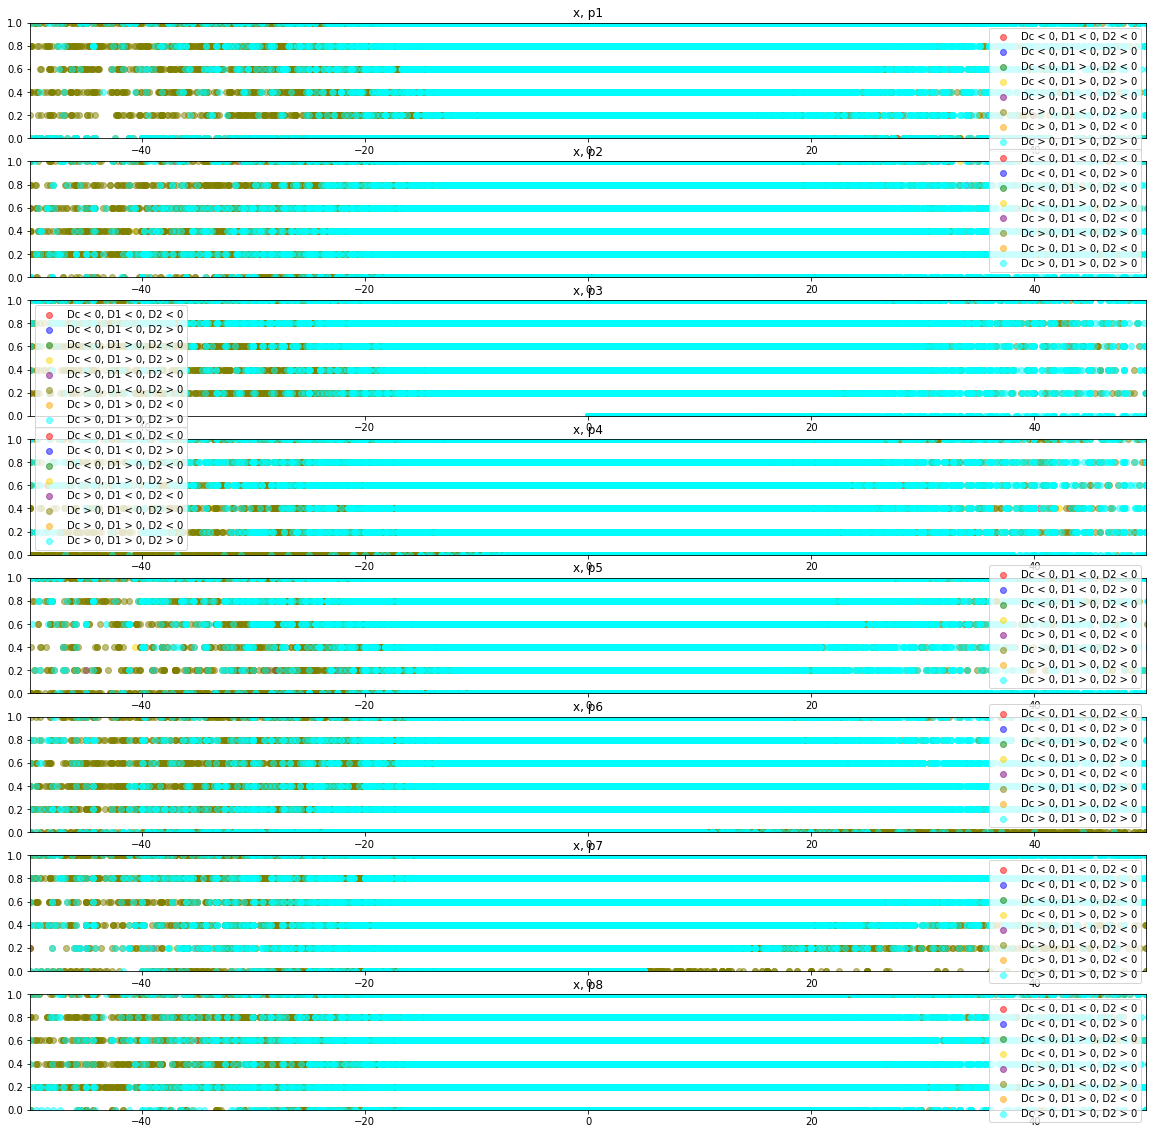

In [22]:
fig, axs = plt.subplots(8, 1, figsize=(20, 20))

for i in range(8):
    axis_1 = 'x'
    axis_2 = params[i]
    
    for j in range(8):
        axs[i].scatter(biffurc_borders_df[biffurc_borders_df['Space'] == j][axis_1], biffurc_borders_df[biffurc_borders_df['Space'] == j][axis_2], color=colors[j], label=spaces[j], alpha=0.5)
        
    axs[i].set_title(axis_1 + ", " + axis_2)
    axs[i].set_xlim([-50, 50])
    axs[i].set_ylim([0, 1])
    axs[i].legend()

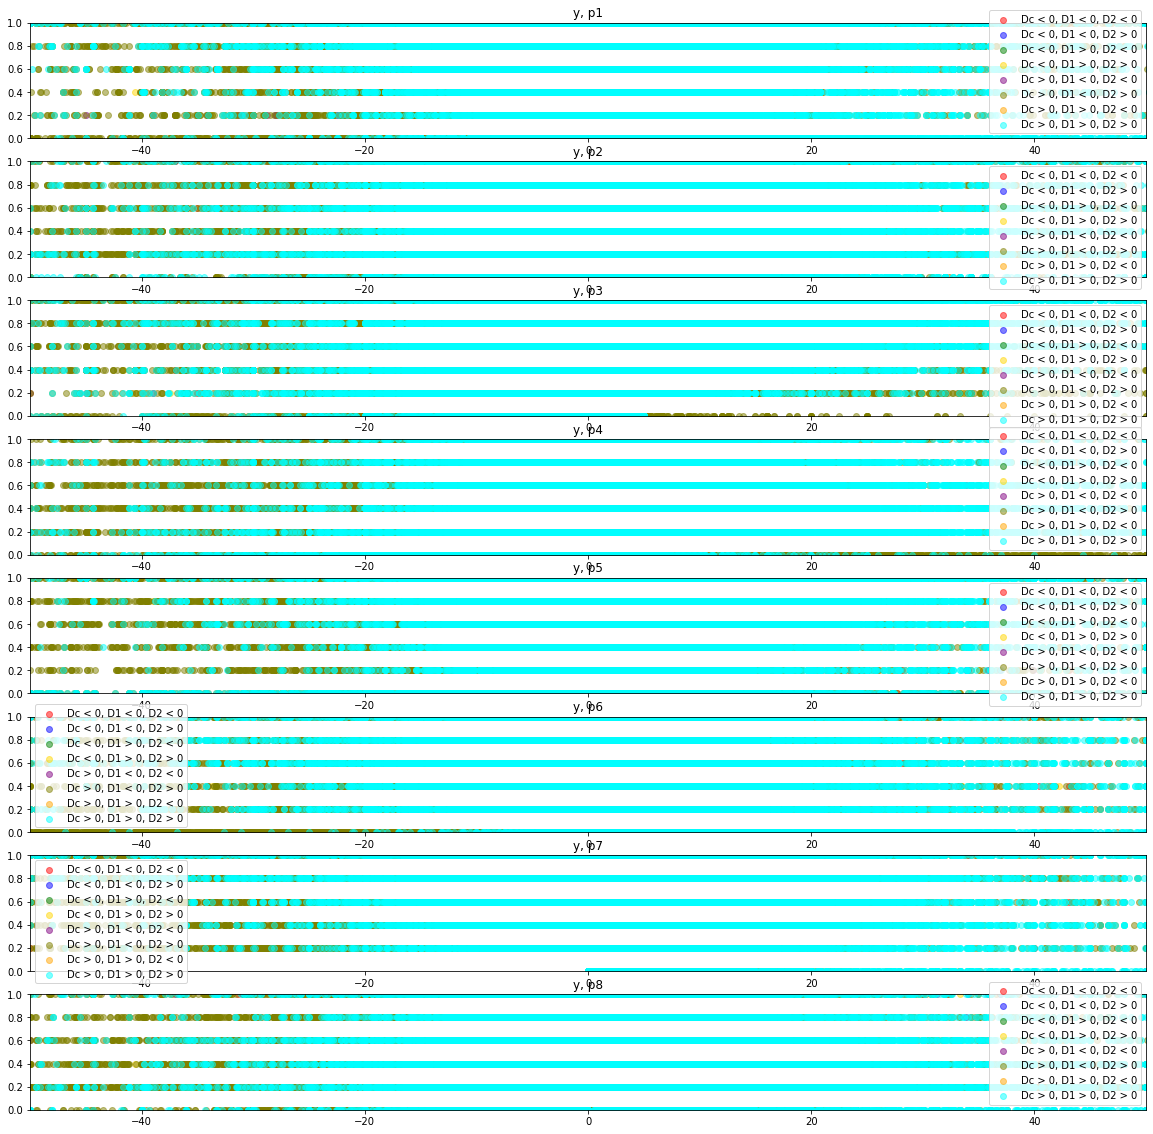

In [24]:
fig, axs = plt.subplots(8, 1, figsize=(20, 20))

for i in range(8):
    axis_1 = 'y'
    axis_2 = params[i]
    
    for j in range(8):
        axs[i].scatter(biffurc_borders_df[biffurc_borders_df['Space'] == j][axis_1], biffurc_borders_df[biffurc_borders_df['Space'] == j][axis_2], color=colors[j], label=spaces[j], alpha=0.5)
        
    axs[i].set_title(axis_1 + ", " + axis_2)
    axs[i].set_xlim([-50, 50])
    axs[i].set_ylim([0, 1])
    axs[i].legend()

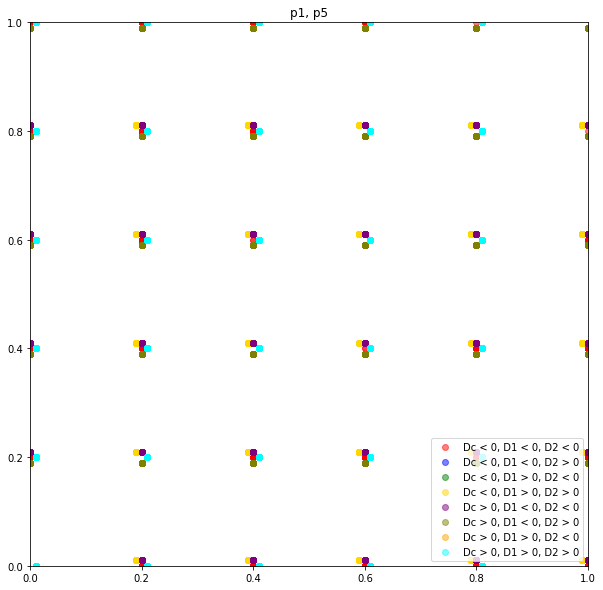

In [26]:
plt.figure(figsize=(10, 10))
axis_1 = 'p1'
axis_2 = 'p5'

plt.scatter(biffurc_borders_df[biffurc_borders_df['Space'] == 0][axis_1], biffurc_borders_df[biffurc_borders_df['Space'] == 0][axis_2], color=colors[0], label=spaces[0], alpha=0.5)
plt.scatter(biffurc_borders_df[biffurc_borders_df['Space'] == 1][axis_1]-0.01, biffurc_borders_df[biffurc_borders_df['Space'] == 1][axis_2]-0.01, color=colors[1], label=spaces[1], alpha=0.5)
plt.scatter(biffurc_borders_df[biffurc_borders_df['Space'] == 2][axis_1]-0.01, biffurc_borders_df[biffurc_borders_df['Space'] == 2][axis_2], color=colors[2], label=spaces[2], alpha=0.5)
plt.scatter(biffurc_borders_df[biffurc_borders_df['Space'] == 3][axis_1]-0.01, biffurc_borders_df[biffurc_borders_df['Space'] == 3][axis_2] + 0.01, color=colors[3], label=spaces[3], alpha=0.5)
plt.scatter(biffurc_borders_df[biffurc_borders_df['Space'] == 4][axis_1], biffurc_borders_df[biffurc_borders_df['Space'] == 4][axis_2] + 0.01, color=colors[4], label=spaces[4], alpha=0.5)
plt.scatter(biffurc_borders_df[biffurc_borders_df['Space'] == 5][axis_1], biffurc_borders_df[biffurc_borders_df['Space'] == 5][axis_2]-0.01, color=colors[5], label=spaces[5], alpha=0.5)
plt.scatter(biffurc_borders_df[biffurc_borders_df['Space'] == 6][axis_1] + 0.01, biffurc_borders_df[biffurc_borders_df['Space'] == 6][axis_2]-0.01, color=colors[6], label=spaces[6], alpha=0.5)
plt.scatter(biffurc_borders_df[biffurc_borders_df['Space'] == 7][axis_1] + 0.01, biffurc_borders_df[biffurc_borders_df['Space'] == 7][axis_2], color=colors[7], label=spaces[7], alpha=0.5)

plt.title(axis_1 + ", " + axis_2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

Бифуркациионные области отвечающие за число решений:

$$
    \begin{cases}
        \frac{dn_1}{dt} = -\alpha_1 n_1 + d^{(1)}_{11}n^2_1 + 2d^{(1)}_{12}n_1n_2 + d^{(1)}_{22}n^2_2 \\
        \frac{dn_2}{dt} = -\alpha_2 n_2 + d^{(2)}_{11}n^2_1 + 2d^{(2)}_{12}n_1n_2 + d^{(2)}_{22}n^2_2 \\
    \end{cases} \: \clubsuit
$$

1 решение

$$
    \begin{cases}
        \alpha_1 \neq 0 \\
        \alpha_2 \neq 0 \\
        d^{(1)}_{22} \neq 0 \\
        d^(2)_{22} \neq 0 \\
        \frac{d^{(1)}_{12}d^{(2)}_{22}}{\alpha^2_1} - \frac{d^{(1)}_{22}d^{(2)}_{12}}{\alpha_2} = 0 \\
        q_3 = 0 \\
        q^2_1 - 4q_2q_0 < 0 \\
        q_2 = 2 \gamma \lambda + 2 \frac{d^{(1)}_{12}}{d^{(1)}_{22}} \\
        q_1 = \lambda^2 + \frac{d^{(1)}_{11}}{d^{(2)}_{22}} + 2 \cdot \frac{d^{(1)}_{12}}{d^{(1)}_{22}} \cdot \lambda \\
        q_0 = -\frac{\alpha_1}{d^{(1)}_{22}} \\
    \end{cases} (1.1.1.2)
$$

$$
    \begin{cases}
        \alpha_1 \neq 0 \\
        \alpha_2 \neq 0 \\
        d^{(1)}_{22} \neq 0 \\
        d^(2)_{22} \neq 0 \\
        q_3 = 0 \\
        q^2 - 4q_1q_0 < 0 \\
        q_2 = 2k_1 \frac{d^{(1)}_{22}}{\alpha_1} \cdot \frac{d^{(2)}_{22}}{\alpha_2} - 4k^2_2 - 4k_2 \frac{d^{(1)}_{11}d^{(1)}_{22}}{\alpha^2_1} + 4k_2 \frac{d^{(1)}_{12}d^{(2)}_{22}}{\alpha_1\alpha_2} + 2k_1\frac{d^{(1)}_{12}d^{(1)}_{22}}{\alpha^2_1}\\
        q_1 = \frac{(d^{(2)}_{22})^2 d^{(1)}_{22}}{\alpha_1\alpha^2_2} - 4k_2 \frac{d^{(1)}_{22}}{\alpha_1} - \frac{d^{(1)}_{11} (d^{(1)}_{22})^2}{\alpha^3_1} + 2 \frac{d^{(1)}_{12} d^{(1)}_{22} d^{(2)}_{22}}{\alpha^2_1\alpha_2} \\
                q_0 = -\frac{d^{(1)}_{22}}{\alpha_1} \\
        k_1 = \frac{d^{(1)}_{22}d^{(2)}_{11}}{\alpha_1\alpha_2} - \frac{d^{(1)}_{11}d^{(2)}_{22}}{\alpha_1\alpha_2} \\
        k_2 = \frac{d^{(1)}_{12}d^{(2)}_{22}}{\alpha_1\alpha_2} - \frac{d^{(2)}_{12}d^{(1)}_{22}}{\alpha_1\alpha_2} \\
    \end{cases} (1.1.1.1)\\
$$

$$
    \begin{cases}
        \alpha_1 \neq 0 \\
        \alpha_2 \neq 0 \\
        \frac{d^{(1)}_{22}}{\alpha_1} \neq 0 \\
        \frac{d^{(2)}_{22}}{\alpha_2} = 0 \\
        q_3 = 0 \\
        q^2_1 - 4q_2q_0 < 0 \\
        q_3 = \frac{d^{(1)}_{22}d^{(2)}_{11}}{\alpha_1\alpha^2_2} \\
        q_2 = -4\frac{(d^{(2)}_{12})^2}{\alpha^2_2} - 4 \frac{d^{(1)}_{11}d^{(2)}_{12}}{\alpha_1 \alpha_2} \\
        q_1 = 4 \frac{d^{(2)}_{12}}{\alpha_2} + \frac{d^{(1)}_{11}}{\alpha_1} + 4 \frac{d^{(1)}_{11}d^{(2)}_{12}}{\alpha_1\alpha_2} - 4 \frac{d^{(1)}_{12}d^{(2)}_{12}}{\alpha_1 \alpha_2} \\
        q_0 = 2 \frac{d^{(1)}_{12}}{\alpha_1} - 1
    \end{cases} (1.2.1.1)
$$

$$
    \begin{cases}
        \alpha_1 \neq 0 \\
        \alpha_2 \neq 0 \\
        \frac{d^{(1)}_{22}}{\alpha_1} \neq 0 \\
        \frac{d^{(2)}_{22}}{\alpha_2} = 0 \\
        x = \frac{\alpha_2}{2d^{(2)}_{12}} \\
        q^2_1 - 4 q_2 q_0 < 0 \\
        q_2 = \frac{d^{(1)}_{22}}{\alpha_1} \\
        q_1 = \frac{\alpha_2 d^{(1)}_{12}}{\alpha_1 d^{(2)}_{12}} \\
        q_0 = \frac{\alpha_2}{2d^{(2)}_{12}} - \frac{d^{(1)}_{11} \alpha^2_2}{(d^{(2)}_{12})^2} \\
    \end{cases} (1.2.2)
$$

$$
    \begin{cases}
        \alpha_1 \neq 0 \\
                \alpha_2 \neq 0 \\
        \frac{d^{(1)}_{22}}{\alpha_1} \neq 0 \\
        \frac{d^{(2)}_{22}}{\alpha_2} \neq 0 \\
        \frac{d^{(1)}_{12}}{\alpha_1} \neq 0 \\
        q^2_1 - 4q_2q_0 < 0 \\ 
        q_2 = 4 \frac{(d^{(1)}_{12})^2d^{(2)}_{11}}{\alpha^2_1\alpha_2} - 4 \frac{d^{(2)}_{12}d^{(1)}_{11}d^{(1)}_{12}}{\alpha^2_1\alpha_2} + \frac{(d^{(1)}_{11})^2 d^{(2)}_{22}}{\alpha^2_1\alpha_2} \\
    q_1 = 4 \frac{d^{(1)}_{12}d^{(2)}_{12}}{\alpha_1 \alpha_2} - 2 \frac{d^{(1)}_{11}d^{(2)}_{22}}{\alpha_1\alpha_2} + 
    2\frac{d^{(1)}_{12}d^{(1)}_{11}}{\alpha^2_1}\\
    q_0 = \frac{d^{(2)}_{22}}{\alpha_2} - 2\frac{d^{(1)}_{12}}{\alpha_1} \\
    \end{cases} (1.3.1.1)
$$

$$
    \begin{cases}
        \alpha_1 \neq 0 \\
        \alpha_2 \neq 0 \\
        \frac{d^{(1)}_{22}}{\alpha_1} \neq 0 \\
        \frac{d^{(2)}_{22}}{\alpha_2} \neq 0 \\
        \frac{d^{(1)}_{12}}{\alpha_1} = 0 \\
        q^2_1 - 4q_2q_0 < 0 \\ 
        q_2 = \frac{d^{(2)}_{22}}{\alpha_2} \\
        q_1 = 2\frac{\alpha_1 d^{(2)}_{12}}{d^{(1)}_{11}} - 1 \\
        q_0 = \frac{\alpha^2_1 d^{(2)}_{11}}{(d^{(1)}_{11})^2} \\
    \end{cases} (1.3.2.2)
$$

$$
    \begin{cases}
        \alpha_1 \neq 0 \\
        \alpha_2 \neq 0 \\
        \frac{d^{(1)}_{22}}{\alpha_1} = 0 \\
        \frac{d^{(2)}_{22}}{\alpha_2} = 0 \\
        \frac{d^{(1)}_{12}}{\alpha_1} \neq 0 \\
        q^2_1 - 4q_2q_0 < 0 \\
        q_2 = 2\frac{d^{(1)}_{12}d^{(2)}_{11}}{\alpha_1\alpha_2} - 2 \frac{d^{(2)}_{12}d^{(1)}_{11}}{\alpha_1 \alpha_2} \\
        q_0 = -1 \\
    \end{cases} (1.4.1)
$$

$$
    \begin{cases}
        \alpha_1 \neq 0 \\
        \alpha_2 \neq 0 \\
        \frac{d^{(1)}_{22}}{\alpha_1} = 0 \\
        \frac{d^{(2)}_{22}}{\alpha_2} = 0 \\
        \frac{d^{(1)}_{12}}{\alpha_1} = 0 \\
        \frac{d^{(1)}_{11}}{\alpha_1} = 0 \\
    \end{cases} (1.4.2)
$$

$$
    \begin{cases}
    \alpha_1 = 0 \\
    \alpha_2 \neq 0 \\
    d^{(1)}_{22} \neq 0 \\
    \frac{d^{(2)}_{22}}{\alpha_2} \neq 0 \\
    q^2_1 - 4q_2q_0 < 0 \\
    q_2 = k^2_1 + 4d^{(1)}_{11}k^2_2 + 2k_1k_2 \\
    q_1 = k_1 d^{(1)}_{22} + 4 d^{(1)}_{11}k_2 d^{(1)}_{22} \\
    q_0 = d^{(1)}_{11} (d^{(1)}_{12})^2 \\
    k_1 = \frac{d^{(1)}_{22} d^{(2)}_{11}}{\alpha_2} - \frac{d^{(1)}_{11}d^{(2)}_{22}}{\alpha_2} \\
    k_2 = \frac{d^{(1)}_{12} d^{(2)}_{22}}{\alpha_2} - \frac{d^{(1)}_{22}d^{(2)}_{12}}{\alpha_2} \\
    \end{cases} (2.1)
$$

$$
    \begin{cases}
        \alpha_1 = 0 \\
        \alpha_2 \neq 0 \\
        d^{(1)}_{22} = 0 \\
        \frac{d^{(2)}_{22}}{\alpha_2} \neq 0 \\
        d^{(1)}_{12} \neq 0 \\
        d^{(1)}_{11} = 0 \\
    \end{cases} (2.2)
$$

$$
    \begin{cases}
        \alpha_1 = 0 \\
        \alpha_2 \neq 0 \\
        d^{(1)}_{22} = 0 \\
        \frac{d^{(2)}_{22}}{\alpha_2} = 0 \\
        d^{(1)}_{12} = 0 \\
    \end{cases} (2.4.1)
$$

$$
    \begin{cases}
        \alpha_1 = 0 \\
        \alpha_2 \neq 0 \\
        d^{(1)}_{22} = 0 \\
        d^{(2)}_{22} = 0 \\
        d^{(1)}_{11} = 0 \\
    \end{cases} (2.4.2)
$$

$$
    \begin{cases}
            \alpha_1 \neq 0 \\
    \alpha_2 = 0 \\
    d^{(1)}_{22} \neq 0 \\
    d^{(2)}_{22} \neq 0 \\
    \frac{d^{(1)}_{12} d^{(2)}_{22}}{\alpha_1} - \frac{d^{(1)}_{22} d^{(2)}_{12}}{\alpha_1} = 0 \\
    q^2_1 - 4q_2q_0 < 0 \\
    q_2 = 1 \\
    q_1 = \frac{2d^{(2)}_{12}}{d^{(1)}_{22}} \\
    q_0 = \frac{d^{(1)}_{12} d^{(2)}_{22}}{(d^{(1)}_{22})^2} \\
    \end{cases} (3.1.1)
$$

$$
    \begin{cases}
        \alpha_1 \neq 0 \\
        \alpha_2 = 0 \\
        d^{(1)}_{22} \neq 0 \\
        d^{(2)}_{22} \neq 0 \\
        \frac{d^{(1)}_{12} d^{(2)}_{22}}{\alpha_1} - \frac{d^{(1)}_{22} d^{(2)}_{12}}{\alpha_1} \neq 0 \\
        q^2_1 - 4q_2q_0 < 0 \\
        q_2 = k^2_1 d^{(2)}_{22} + 4k^2_2 d^{(2)}_{11} - 4k_1k_2 d^{(2)}_{12} \\
        q_1 = 2k_1 (d^{(2)}_{22})^2 - 4k_2 d^{(2)}_{12}d^{(2)}_{22} \\
        q_0 = (d^{(2)}_{22})^3 \\
        k_1 = \frac{d^{(1)}_{22} d^{(2)}_{11}}{\alpha_1} - \frac{d^{(1)}_{11} d^{(2)}_{22}}{\alpha_1} \\
        k_2 = \frac{d^{(1)}_{12} d^{(2)}_{22}}{\alpha_1} - \frac{d^{(2)}_{12} d^{(1)}_{22}}{\alpha_1} \\
    \end{cases} (3.1.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' \neq 0 \\
        h \neq 0 \\
        d' = 0 \\
        c' = 0 \\
    \end{cases} (3.2.1.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' = 0 \\
        h \neq 0 \\
        d = 0 \\
        d' = 0 \\
        c' \neq 0 \\
        q^2_2 - 4q_0q_1 < 0 \\
        q_0 = \frac{f}{c'^2} \\
        q_1 = \frac{2g}{c'} \\
        q_2 = h \\
    \end{cases} (3.2.1.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' = 0 \\
        h \neq 0 \\
        d \neq 0 \\
        q^2_2 - 4q_0q_1 < 0 \\
        q_0 = h \\
        q_1 = 4d'g - 2c'h \\
        q_2 = 4d'^2f' - 4d'gc' - c'^2h \\
    \end{cases} (3.2.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' \neq 0 \\
        h = 0 \\
        g = 0 \\
    \end{cases} (3.3.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' = 0 \\
        h = 0 \\
        g = 0 \\
    \end{cases} (3.4.1)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta = 0 \\
        e \neq 0 \\
        h \neq 0 \\
        ge - dh = 0 \\
    \end{cases} (4.1.1)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta = 0 \\
        e = 0 \\
        h \neq 0 \\
        d = 0 \\
    \end{cases} (4.2.1)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta = 0 \\
        e \neq 0 \\
        h = 0 \\
        g = 0 \\
    \end{cases} (4.3.1)
$$

2 решения

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' \neq 0 \\
        q_3 \neq 0 \\
        q^2_2q^2_1 - 4q_3q^3_1 - 4q^3_2q_0 - 27q^2_3q^2_0 + 18q_3q_2q_1q_0 < 0 \\
        x = 0; y = 0 \\
        x = -\frac{1}{q_3} \left(q_2 + \lambda + \frac{D_0}{\lambda}\right); y = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        k_1 = e'f' - h'c' \\
        k_2 = (d'h' - g'e') \\
        q_0 = -e' \\
        q_1 = h'^2e' - 4k_2e' - c'e'^2 + 4d'h'e' \\
        q_2 = 2k_1h'e' - 4k^2_2 - 4k_2e'c' + 4d'h'k_2 + 2d'k_1e' \\
        q_3 = k^2_1e' + 4k^2_2c' + 4d'k_1k_2 \\ 
        D_0 = q^2_2 - 3q_3q_1 \\
        D_1 = 2q^3_2 - 9q_3q_2q_1 + 27q^2_3q_0 \\
        C = \sqrt[3]{\frac{D_1 + \sqrt{D^2_1 - 4D^3_0}}{2}} \\
    \end{cases} (1.1.1.1.1)
$$

$$
     \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' \neq 0 \\
        q_3 = 0 \\
        q_2 \neq 0 \\
        q^2_1 - 4q_2q_0 = 0 \\
        x = 0; y = 0 \\
        x =  \frac{-q_1 + \sqrt{q^2_1 - 4q_2q_0}}{2q_2}; y = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        k_1 = e'f' - h'c' \\
        k_2 = d'h' - g'e' \\
        q_0 = -e' \\
        q_1 = h'^2e' - 4k_2e' - c'e'^2 + 4d'h'e' \\
        q_2 = 2k_1h'e' - 4k^2_2 - 4k_2e'c' + 4d'h'k_2 + 2d'k_1e' \\
        q_3 = k^2_1e' + 4k^2_2c' + 4d'k_1k_2 \\ 
    \end{cases} (1.1.1.1.2)
$$

$$
     \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' \neq 0 \\
        q_3 = 0 \\
        q_2 = 0 \\
        x = 0; y = 0 \\
        x = -\frac{q_0}{q_1} ; y = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        k_1 = e'f' - h'c' \\
        k_2 = d'h' - g'e' \\
        q_0 = -e' \\
        q_1 = h'^2e' - 4k_2e' - c'e'^2 + 4d'h'e' \\
        q_2 = 2k_1h'e' - 4k^2_2 - 4k_2e'c' + 4d'h'k_2 + 2d'k_1e' \\
        q_3 = k^2_1e' + 4k^2_2c' + 4d'k_1k_2 \\ 
    \end{cases} (1.1.1.1.3)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' = 0 \\
        q_3 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = -\frac{1}{q_3} \left(q_2 + \lambda + \frac{D_0}{\lambda}\right) ; y_2 = \frac{f'x^2}{1 - 2g'x} \\
        q_0 = 2d' - 1 \\
        q_1 = 4g' + c' + 4c'g' - 4d'g' \\
        q_2 = -4g'^2 - 4c'g' \\
        q_3 = e'f'^2 \\
        D_0 = q^2_2 - 3q_3q_1 \\
        D_1 = 2q^3_2 - 9q_3q_2q_1 + 27q^2_3q_0 \\
        C = \sqrt[3]{\frac{D_1 + \sqrt{D^2_1 - 4D^3_0}}{2}} \\
    \end{cases} (1.2.1.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' = 0 \\
        h' \neq 0 \\
        d' \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 =  \frac{-q_1 + \sqrt{q^2_1 - 4q_2q_0}}{2q_2} ; y_2 = \frac{1-c'x}{2d'} \\
        q_2 = 4d'^2f' - 4g'c'd' + c'^2h' \\
        q_1 = 4d'g' - 2c'h' + 2f'c' \\
        q_0 = h' - 2d' \\
    \end{cases} (1.3.1.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' = 0 \\
        h' \neq 0 \\
        d' \neq 0 \\
        q_2 = 0 \\
        q_1 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 =  -\frac{q_0}{q_1} ; y_2 = \frac{1-c'x}{2d'} \\
        q_2 = 4d'^2f' - 4g'c'd' + c'^2h' \\
        q_1 = 4d'g' - 2c'h' + 2f'c' \\
        q_0 = h' - 2d' \\    
    \end{cases} (1.3.1.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' = 0 \\
        h' \neq 0 \\
        d' = 0 \\
        c' = 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = 0 ; y_2 = \frac{1}{h'} \\
    \end{cases} (1.3.2.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' = 0 \\
        h' \neq 0 \\
        d' = 0 \\
        c' \neq 0 \\
        q^2_1 - 4q_2q_0 = 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{1}{c'} ; y_2 = \frac{-q_1}{2q_2} \\
        q_2 = h' \\
        q_1 = \frac{2g'}{c'} - 1 \\
        q_0 = \frac{f'}{c'^2} \\
    \end{cases} (1.3.2.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' = 0 \\
        h' = 0 \\
        d' \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{-q_1}{2q_2} ; y_2 = \frac{1-c'x}{2d'} \\
        q^2_1 - 4q_2q_0 = 0 \\
        q_2 = 2d'f' - 2g'c' \\
        q_1 = 2g' + c' \\
        q_0 = -1 \\
    \end{cases} (1.4.1.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' = 0 \\
        h' = 0 \\
        d' \neq 0 \\
        q_1 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{-q_0}{q_1} ; y_2 = \frac{1-c'x}{2d'} \\
        2d'f' - 2g'c' = 0\\
        q_1 = 2g' + c' \\
        q_0 = -1 \\
    \end{cases} (1.4.1.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' = 0 \\
        h' = 0 \\
        d' = 0 \\
        c'\neq 0 \\
        \frac{2g'}{c'} - 1 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{1}{c'} ; y_2 = \frac{f'}{c'(c'-2g')} \\
    \end{cases} (1.4.2)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e \neq 0 \\
        h' \neq 0 \\
        x_1 = 0; y_1 = 0 \\
        q_2 \neq 0 \\
        q^2_1 - 4q_2q_0 = 0 \\
        x_2 = \frac{-q_1}{2q_2}; y_2 = \frac{k_1x^2}{2k_2x + e} \\
        q_2 = k^2_1 + 4ck^2_2 + 2k_1k_2 \\
        q_1 = k_1e + 4ck_2e \\
        q_0 = ce^2 \\
    \end{cases} (2.1.1)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e \neq 0 \\
        h' \neq 0 \\
        x_1 = 0; y_1 = 0 \\
        q_2 = 0 \\
        q_1 \neq 0 \\
        q_0 \neq 0 \\
        x_2 = -\frac{q_0}{q_1}; y_2 = \frac{k_1x^2}{2k_2x + e} \\
        q_2 = k^2_1 + 4ck^2_2 + 2k_1k_2 \\
        q_1 = k_1e + 4ck_2e \\
        q_0 = ce^2 \\
    \end{cases} (2.1.2)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e = 0 \\
        h' \neq 0 \\
        d = 0 \\
        x_1 = 0; y_1 = 0 \\
        x_2 = 0; y_2 = \frac{1}{h'} \\
    \end{cases} (2.2.1)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e = 0 \\
        h' \neq 0 \\
        d \neq 0 \\
        q_1 \neq 0 \\
        q_0 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = -\frac{q_0}{q_1} ; y_2 = -\frac{c}{2d}x
    \end{cases} (2.2.2)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e \neq 0 \\
        h' = 0 \\
        g' = 0 \\
        x_1 = 0; y_1 = 0 \\
        x_2 = -\frac{d}{ef'}; y_2 = f'x^2 \\
        ef' \neq 0 \\
        4d^2 - 4ef' = 0 \\
    \end{cases} (2.3.1)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e \neq 0 \\
        h' = 0 \\
        g' = 0 \\
        x_1 = 0; y_1 = 0 \\
        x_2 = -\frac{c}{2d}; y_2 = f'x^2 \\
        ef' = 0 \\
        d \neq 0 \\
        c \neq 0 \\
    \end{cases} (2.3.2)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e \neq 0 \\
        h' = 0 \\
        g' = 0 \\
        x_1 = 0; y_1 = 0 \\
        x_2 = -\frac{c}{2d}; y_2 = f'x^2 \\
        ef' = 0 \\
        d \neq 0 \\
        c \neq 0 \\
    \end{cases} (2.3.3)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e \neq 0 \\
        h' = 0 \\
        g' \neq 0 \\
        x \neq \frac{1}{2g'} \\
        q_2 = ef'^2 + 4cg'^2 - 4dg'f' \\
        q_1 = 2df' - 4cg' \\
        q_0 = c \\
        q_2 \neq 0 \\
        q^2_1 - 4q_0q_2 = 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 =  -\frac{q_1}{2q_2}; y_2 = \frac{f'x^2}{1-2g'x} \\
        ef' = 0 \\
    \end{cases} (2.3.4)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e \neq 0 \\
        h' = 0 \\
        g' \neq 0 \\
        x \neq \frac{1}{2g'} \\
        q_2 = ef'^2 + 4cg'^2 - 4dg'f' \\
        q_1 = 2df' - 4cg' \\
        q_0 = c \\
        q_2 = 0 \\
        q_1 \neq 0 \\
        q_0 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 =  -\frac{q_0}{q_1}; y_2 = \frac{f'x^2}{1-2g'x} \\
        ef' = 0 \\
    \end{cases} (2.3.5)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e = 0 \\
        h' = 0 \\
        d \neq 0 \\
        c \neq 0 \\
        q_1 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = -\frac{c}{q_1} ; y = -\frac{c}{2d}x \\
        q_1 = 2df' - 2g'c \\
    \end{cases} (2.4)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' \neq 0 \\
        h \neq 0 \\
        k_2 = 0 \\
        k_1 = e'f - c'h \\
        k_2 = d'h - ge' \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{h}{k_1} ; y_2 = -\frac{g}{k_1} \\
        q_1 = \frac{2g}{k_1} \\
        q_0 = \frac{dh}{k^2_1} \\
        q^2_1 - 4q_0 = 0
    \end{cases} (3.1.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' \neq 0 \\
        h \neq 0 \\
        k_2 \neq 0 \\
        k_1 = e'f - c'h \\
        k_2 = d'h - ge' \\
        q_2 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = -\frac{q_1}{2q_2} ; y_2 = \frac{k_1x + h}{2k_2} \\
        q_2 = k^2_1h + 4k^2_2f - 4k_1k_2g \\
        q_1 = 2k_1h^2 - 4k_2hg \\
        q_0 = h^3 \\
        q^2_1 - 4q_0q_2 = 0
    \end{cases} (3.1.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' \neq 0 \\
        h \neq 0 \\
        k_2 \neq 0 \\
        k_1 = e'f - c'h \\
        k_2 = d'h - ge' \\
        q_2 = 0 \\
        q_1 \neq 0 \\
        q_0 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = -\frac{q_0}{q_1} ; y_2 = \frac{k_1x + h}{2k_2} \\
        q_2 = k^2_1h + 4k^2_2f - 4k_1k_2g \\
        q_1 = 2k_1h^2 - 4k_2hg \\
        q_0 = h^3 \\
    \end{cases} (3.1.3)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' = 0 \\
        h \neq 0 \\
        d = 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{1}{c'} ; y_2 = -\frac{g}{c'h} \\
        \frac{4g^2}{c'^2} - 4 \frac{hf}{c'^2} = 0 \\
    \end{cases} (3.2.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' = 0 \\
        h \neq 0 \\
        d \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = -\frac{q_1}{2q_2} ; y_2 = \frac{1-c'x}{2d'} \\
        q_2 = 4d'^2f' - 4d'gc' - c'^2h \\
        q_1 = 4d'g - 2c'h \\
        q_0 = h \\
        q_2 \neq 0 \\
        q^2_1 - 4q_0q_2 = 0 \\
    \end{cases} (3.2.2.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e' = 0 \\
        h \neq 0 \\
        d \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = -\frac{q_0}{q_1} ; y_2 = \frac{1-c'x}{2d'} \\
        q_2 = 4d'^2f' - 4d'gc' - c'^2h \\
        q_1 = 4d'g - 2c'h \\
        q_0 = h \\
        q_2 = 0 \\
        q_1 \neq 0 \\
        q_0 \neq 0 \\
    \end{cases} (3.2.2.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e \neq 0 \\
        h = 0 \\
        g \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        q_1 \neq 0 \\
        q_1 = e'f^2 + 4g^2c' - 4gd'f \\
        x_2 = \frac{1}{q_1} ; y_2 = -\frac{f}{2g}x \\
    \end{cases} (3.3.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e = 0 \\
        h = 0 \\
        g \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        q_1 \neq 0 \\
        q_1 = gc' - fd' \\
        x_2 = \frac{g}{q_1} ; y_2 = -\frac{f}{2g}x \\
    \end{cases} (3.4.2)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta = 0 \\
        e \neq 0 \\
        h = 0 \\
        g \neq 0 \\
        q_1 = 2gc - 2df \\
        q_1 \neq 0 \\
        f \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{ef}{q_1} ; y_2 = -\frac{f}{2g}x \\
    \end{cases}
$$

3 решения

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' \neq 0 \\
        q_3 \neq 0 \\
        q^2_2q^2_1 - 4q_3q^3_1 - 4q^3_2q_0 - 27q^2_3q^2_0 + 18q_3q_2q_1q_0 = 0 \\
        x_1 = 0; y_1 = 0 \\
        x_2 = -\frac{1}{q_3} \left(q_2 + \lambda + \frac{D_0}{\lambda}\right); y_2 = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        x_3 = -\frac{1}{q_3} \cdot \left(q_2 + \frac{-1 + \sqrt{3}}{2} C + \frac{2D_0}{(-1 + \sqrt{3})C}\right) ; y_3 = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        k_1 = e'f' - h'c' \\
        k_2 = (d'h' - g'e') \\
        q_0 = -e' \\
        q_1 = h'^2e' - 4k_2e' - c'e'^2 + 4d'h'e' \\
        q_2 = 2k_1h'e' - 4k^2_2 - 4k_2e'c' + 4d'h'k_2 + 2d'k_1e' \\
        q_3 = k^2_1e' + 4k^2_2c' + 4d'k_1k_2 \\ 
        D_0 = q^2_2 - 3q_3q_1 \\
        D_1 = 2q^3_2 - 9q_3q_2q_1 + 27q^2_3q_0 \\
        C = \sqrt[3]{\frac{D_1 + \sqrt{D^2_1 - 4D^3_0}}{2}} \\
    \end{cases} (1.1.1.1.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' \neq 0 \\
        q_3 = 0 \\
        q_2 \neq 0 \\
        D = q^2_1 - 4q_0q_2 \\
        D > 0 \\
        x_1 = 0; y_1 = 0 \\
        x_2 = \frac{-q_1 + \sqrt{D}}{2q_2}; y_2 = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        x_3 = \frac{-q_1 - \sqrt{D}}{2q_2} ; y_3 = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        k_1 = e'f' - h'c' \\
        k_2 = (d'h' - g'e') \\
        q_0 = -e' \\
        q_1 = h'^2e' - 4k_2e' - c'e'^2 + 4d'h'e' \\
        q_2 = 2k_1h'e' - 4k^2_2 - 4k_2e'c' + 4d'h'k_2 + 2d'k_1e' \\
        q_3 = k^2_1e' + 4k^2_2c' + 4d'k_1k_2 \\ 
    \end{cases} (1.1.1.1.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' = 0 \\
        q^2_2q^2_1 - 4q_3q^3_1 - 4q^3_2q_0 - 27q^2_3q^2_0 + 18q_3q_2q_1q_0 = 0 \\
        q_3 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = -\frac{1}{q_3} \left(q_2 + \frac{-1 + \sqrt{3}}{2} C + \frac{2 D_0}{(-1 + \sqrt{3})C}\right) ; y_2 = \frac{f'x^2}{1 - 2g'x} \\
        x_3 = -\frac{1}{q_3} \left(q_2 + C + \frac{D_0}{C}\right) ; y_3 = \frac{f' x^2}{1 - 2g'x} \\
        q_0 = 2d' - 1 \\
        q_1 = 4g' + c' + 4c'g' - 4d'g' \\
        q_2 = -4g'^2 - 4c'g' \\
        q_3 = e'f'^2 \\
        D_0 = q^2_2 - 3q_3q_1 \\
        D_1 = 2q^3_2 - 9q_3q_2q_1 + 27q^2_3q_0 \\
        C = \sqrt[3]{\frac{D_1 + \sqrt{D^2_1 - 4D^3_0}}{2}} \\
    \end{cases} (1.2.1.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' = 0 \\
        q^2_2q^2_1 - 4q_3q^3_1 - 4q^3_2q_0 - 27q^2_3q^2_0 + 18q_3q_2q_1q_0 = 0 \\
        q_3 = 0 \\
        q_2 \neq 0 \\
        D = q^2_1 - 4q_0q_2 \\
        D > 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 =  \frac{-q_1 + \sqrt{D}}{2q_2} ; y_2 = \frac{f'x^2}{1 - 2g'x} \\
        x_3 =  \frac{-q_1 - \sqrt{D}}{2q_2} ; y_3 = \frac{f' x^2}{1 - 2g'x} \\
        q_0 = 2d' - 1 \\
        q_1 = 4g' + c' + 4c'g' - 4d'g' \\
        q_2 = -4g'^2 - 4c'g' \\
        q_3 = e'f'^2 \\
        D_0 = q^2_2 - 3q_3q_1 \\
        D_1 = 2q^3_2 - 9q_3q_2q_1 + 27q^2_3q_0 \\
        C = \sqrt[3]{\frac{D_1 + \sqrt{D^2_1 - 4D^3_0}}{2}} \\
    \end{cases} (1.2.1.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e \neq 0 \\
        h = 0 \\
        x_1 = 0 ; y_1 = 0 \\
        q_2 \neq 0 \\
        q_2 = e' \\
        q_1 = \frac{d'}{g'} \\
        q_0 = \frac{1}{2g'} - \frac{c'}{4g'^2} \\
        D = q^2_1 - 4q_0q_2 \\
        D > 0 \\
        x_2 = \frac{1}{2g'} ; y_2 = \frac{-q_1 + \sqrt{D}}{2 q_2} \\
        x_3 = \frac{1}{2g'} ; y_3 = \frac{-q_1 - \sqrt{D}}{2 q_2} \\
    \end{cases} (1.2.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e = 0 \\
        h \neq 0 \\
        d \neq 0 \\
        q_2 = 4d'^2f' - 4g'c'd' + c'^2h' \\
        q_1 = 4d'g' - 2c'h' + 2d'c' \\
        q_0 = h' - 2d' \\
        D = q^2_1 - 4q_0q_2 \\
        D > 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{-q_1 + \sqrt{D}}{2q_2} ; y_2 = \frac{1-c'x}{2d'} \\
        x_3 = \frac{-q_1 - \sqrt{D}}{2q_2} ; y_3 = \frac{1-c'x}{2d'} \\
    \end{cases} (1.3.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e = 0 \\
        h \neq 0 \\
        d = 0 \\
        c \neq 0 \\
        D = \frac{4g'^2}{c'^2} - \frac{4h'f'}{c'^2} > 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{1}{c'} ; y_2 = \frac{\left(-\frac{2g'}{c'} + \sqrt{D}\right)c'^2}{f'} \\
        x_3 = \frac{1}{c'} ; y_3 = \frac{\left(-\frac{2g'}{c'} - \sqrt{D}\right)c'^2}{f'} \\
    \end{cases} (1.3.2)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' = 0 \\
        h' = 0 \\
        d' \neq 0 \\
        q_2 = 2d'f' - 2g'c' \\
        q_1 = 2g' + e' \\
        D = q^2_1 + 4q_2 \\
        D > 0 \\
        q_2 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{-q_1 + \sqrt{D}}{2q_2} ; y_2 = \frac{1-c'x}{2d'} \\
        x_3 = \frac{-q_1 - \sqrt{D}}{2q_2} ; y_3 = \frac{1-c'x}{2d'} \\
    \end{cases} (1.4.1)
$$

$$
    \begin{cases}
        \alpha = 0 \\
        \beta \neq 0 \\
        e \neq 0 \\
        h \neq 0 \\
        k_1 = ef' - ch' \\
        k_2 = h'd - eg' \\
        q_2 = k^2_1 + 4ck^2_2 + 2k_1k_2 \\
        q_1 = k_1e + 4ck_2e \\
        q_0 = ce^2 \\
        q_2 \neq 0 \\
        D = q^2_1 - 4q_0q_2 \\
        D > 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{-q_1 + \sqrt{D}}{2q_2} ; y_2 = \frac{k_1x^2}{2k_2x + e} \\
        x_3 = \frac{-q_1 - \sqrt{D}}{2q_2} ; y_3 = \frac{k_1x^2}{2k_2x + e} \\
    \end{cases} (2.1.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e \neq 0 \\
        h \neq 0 \\
        k_1 = e'f - c'h \\
        k_2 = d'h - ge' \\
        k_2 = 0 \\
        x_1 = 0 ; y_1 = 0 \\
        D = \frac{4g^2}{k^2_1} - \frac{4dh}{k^2_1} \\
        D > 0 \\
        x_2 = \frac{h}{k_1} ; y_2 = \frac{-\frac{2g}{k_1} + \sqrt{D}}{2} \\
        x_3 = \frac{h}{k_1} ; y_3 = \frac{-\frac{2g}{k_1} - \sqrt{D}}{2} \\
    \end{cases} (3.1.1) 
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e \neq 0 \\
        h \neq 0 \\
        k_1 = e'f - c'h \\
        k_2 = d'h - ge' \\
        k_2 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        q_2 = k^2_1h + 4k^2_2f - 4k_1k_2g \\
        q_1 = 2k_1h^2 - 4k_2hg \\
        q_0 = h^3 \\
        D = q^2_1 - 4q_2q_0 \\
        D > 0 \\
        x_2 = \frac{-q_1 + \sqrt{D}}{2 q_2} ; y_2 = \frac{k_1x + h}{2k_2} \\
        x_3 = \frac{-q_1 - \sqrt{D}}{2 q_2} ; y_3 = \frac{k_1x + h}{2k_2} \\
    \end{cases} (3.1.2) 
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e = 0 \\
        h \neq 0 \\
        d = 0 \\
        c \neq 0 \\
        D = \frac{4g^2}{c'^2} - \frac{4hf}{c'^2} > 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{1}{c'} ; y_2 = \frac{\left(-\frac{2g}{c'} + \sqrt{D}\right)c'^2}{2f} \\ 
        x_3 = \frac{1}{c'} ; y_3 = \frac{\left(-\frac{2g}{c'} - \sqrt{D}\right)c'^2}{2f} \\
    \end{cases} (3.2.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta = 0 \\
        e = 0 \\
        h \neq 0 \\
        d \neq 0 \\
        q_2 = 4d'^2f' - 4d'gc' - c'^2h \\
        q_1 = 4d'g - 2c'h \\
        q_0 = h \\
        q_2 \neq 0 \\
        D = q^2_1 - 4q_2q_0 > 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = \frac{-q_1 + \sqrt{D}}{2q_2} ; y_2 = \frac{1 - c'x}{2d'} \\
        x_3 = \frac{-q_1 - \sqrt{D}}{2q_2} ; y_3 = \frac{1 - c'x}{2d'} \\
    \end{cases} (3.2.2)
$$

4 решения


$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' \neq 0 \\
        q_3 \neq 0 \\
        q^2_2q^2_1 - 4q_3q^3_1 - 4q^3_2q_0 - 27q^2_3q^2_0 + 18q_3q_2q_1q_0 > 0 \\
        x_1 = 0; y_1 = 0 \\
        x_2 = -\frac{1}{q_3} \left(q_2 + C + \frac{D_0}{C}\right); y_2 = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        x_3 = -\frac{1}{q_3} \cdot \left(q_2 + \frac{-1 + \sqrt{3}}{2} C + \frac{2D_0}{(-1 + \sqrt{3})C}\right) ; y_3 = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        x_4 = -\frac{1}{q_3} \cdot \left(q_2 + \frac{2 - \sqrt{3}}{2} C + \frac{2D_0}{(2 - \sqrt{3})C}\right); y_4 = \frac{k_1x^2 + h'x}{2k_2 x + e'} \\
        k_1 = e'f' - h'c' \\
        k_2 = (d'h' - g'e') \\
        q_0 = -e' \\
        q_1 = h'^2e' - 4k_2e' - c'e'^2 + 4d'h'e' \\
        q_2 = 2k_1h'e' - 4k^2_2 - 4k_2e'c' + 4d'h'k_2 + 2d'k_1e' \\
        q_3 = k^2_1e' + 4k^2_2c' + 4d'k_1k_2 \\ 
        D_0 = q^2_2 - 3q_3q_1 \\
        D_1 = 2q^3_2 - 9q_3q_2q_1 + 27q^2_3q_0 \\
        C = \sqrt[3]{\frac{D_1 + \sqrt{D^2_1 - 4D^3_0}}{2}} \\
    \end{cases} (1.1.1.1.1)
$$

$$
    \begin{cases}
        \alpha \neq 0 \\
        \beta \neq 0 \\
        e' \neq 0 \\
        h' = 0 \\
        q^2_2q^2_1 - 4q_3q^3_1 - 4q^3_2q_0 - 27q^2_3q^2_0 + 18q_3q_2q_1q_0 > 0 \\
        q_3 \neq 0 \\
        x_1 = 0 ; y_1 = 0 \\
        x_2 = -\frac{1}{q_3} \left(q_2 + \frac{-1 + \sqrt{3}}{2} C + \frac{2 D_0}{(-1 + \sqrt{3})C}\right) ; y_2 = \frac{f'x^2}{1 - 2g'x} \\
        x_3 = -\frac{1}{q_3} \left(q_2 + C + \frac{D_0}{C}\right) ; y_3 = \frac{f' x^2}{1 - 2g'x} \\
        x_4 = -\frac{1}{q_3} \left(q_2 + \frac{2 - \sqrt{3}}{2} C + \frac{2 D_0}{(2 - \sqrt{3})C}\right) ; y_4 = \frac{f'x^2}{1 - 2g'x} \\
        q_0 = 2d' - 1 \\
        q_1 = 4g' + c' + 4c'g' - 4d'g' \\
        q_2 = -4g'^2 - 4c'g' \\
        q_3 = e'f'^2 \\
        D_0 = q^2_2 - 3q_3q_1 \\
        D_1 = 2q^3_2 - 9q_3q_2q_1 + 27q^2_3q_0 \\
        C = \sqrt[3]{\frac{D_1 + \sqrt{D^2_1 - 4D^3_0}}{2}} \\
    \end{cases} (1.2.1.1)
$$

Р. Гилмор "Прикладная теория катастроф", Йен Постон, Стюарт "Теория катастроф" (Катастрофы высоких порядков). Характеристсика катастроф.